# TP1 : Détection d’anomalies avec Python

---
---

*Jordan Dutel, Ariane Paradan* 

## I. Import des librairies

In [21]:
import importlib  # Importation manquante
import function_TAA as taa
importlib.reload(taa)

import numpy as np
np.set_printoptions(threshold=10000, suppress = True)

import pandas as pd

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerPathCollection
%matplotlib inline

from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix as cm, accuracy_score, roc_curve, precision_recall_curve, auc, f1_score, recall_score, precision_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek

from xgboost import XGBClassifier


from collections import Counter

---

## II. Base de données Mouse

### A. Chargement et analyse rapide

In [33]:
df = taa.load_data("mouse.txt", sep = " ", header = None, names = ["X1", "X2"])

           X1        X2
0    0.456601  0.432806
1    0.611378  0.528625
2    0.450299  0.711606
3    0.639015  0.460744
4    0.628957  0.323470
..        ...       ...
495  0.151506  0.876586
496  0.860308  0.633833
497  0.862083  0.591805
498  0.916030  0.523391
499  0.427325  0.833767

[500 rows x 2 columns]


In [34]:
taa.get_info(df)

### Infos générale ###

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      500 non-null    float64
 1   X2      500 non-null    float64
dtypes: float64(2)
memory usage: 7.9 KB
None

Le dataset contient 500 lignes et 2 colonnes.

### Description ###

               X1          X2
count  500.000000  500.000000
mean     0.505892    0.599706
std      0.191763    0.156863
min      0.040555    0.138940
25%      0.328481    0.469010
50%      0.504702    0.629494
75%      0.681430    0.735364
max      0.916030    0.897028


### Valeurs manquantes ###

X1    0
X2    0
dtype: int64

Le dataset contient 0 valeurs manquantes.

### Colonnes catégorielles ###

=== Nombre de colonnes catégorielles: 0 ===

Index([], dtype='object')

=== Nombre de modalités par colonnes catégorielles ===





### B. Représentation graphique

Text(0.5, 1.0, 'Scatter plot des coordonnées de mouse.txt')

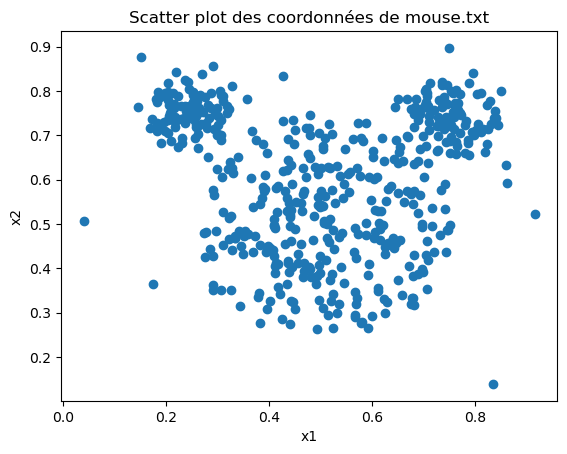

In [6]:
plt.scatter(mouse_data['x1'], mouse_data['x2'])
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Scatter plot des coordonnées de mouse.txt')

### C. Détection d'outlier par Isolation Forest

#### 1. Principe de l'algo

Isolation Forest est un algorithme d'apprentissage non supervisé utilisé pour détecter des anomalies ou des points de données qui sont différents (outliers) dans un ensemble de données. Il est particulièrement efficace pour travailler avec de grandes quantités de données et peut détecter des anomalies sans avoir besoin d'étiquettes (comme dans le cas des anomalies non étiquetées).

L'idée fondamentale derrière l'Isolation Forest repose sur l'idée que les anomalies sont plus faciles à "isoler" que les points normaux. Les anomalies sont souvent éloignées de la majorité des données, ce qui les rend plus faciles à séparer lors de la construction de "arbres" d'isolation.

Voici comment fonctionne l'algorithme :

- Isolation des points de données :
    - Le modèle crée plusieurs arbres (similaires à un arbre de décision), où chaque arbre "divise" les données de manière aléatoire. Pour chaque point, l'algorithme essaie de le séparer des autres points.
    - Les anomalies (points rares ou extrêmes) nécessitent moins de divisions pour être séparées des autres points. En d'autres termes, elles sont plus facilement "isolées" dans les arbres.

- Scores d'anomalie :
    - Chaque point de données reçoit un score d'anomalie basé sur le nombre de divisions nécessaires pour l'isoler. Plus un point a un score élevé, plus il est probable que ce soit une anomalie.
    - Le score est compris entre -1 et 1. Les points avec un score proche de -1 sont considérés comme des anomalies, tandis que ceux proches de 1 sont considérés comme normaux.

#### 2. Arguments de la fonction

- n_estimators :
    - Description : Le nombre d'arbres à utiliser dans la forêt.
    - Valeur par défaut : 100
    - Explication : Plus le nombre d'arbres est élevé, plus l'algorithme est susceptible de donner des résultats stables, mais cela augmentera aussi le temps de calcul. Un nombre typique est entre 100 et 200.

- max_samples :
    - Description : Le nombre maximum de points à utiliser pour entraîner chaque arbre.
    - Valeur par défaut : 'auto' (qui correspond à min(256, n_samples)).
    - Explication : Si tu as un grand nombre de points, tu peux réduire ce paramètre pour accélérer l'entraînement. Utiliser la valeur par défaut est souvent suffisant pour la plupart des cas, mais tu peux ajuster ce paramètre si tu travailles avec des ensembles de données très grands.

- contamination :
    - Description : La proportion estimée d'anomalies dans les données. Ce paramètre aide à déterminer quel seuil utiliser pour classer un point comme anomalie.
    - Valeur par défaut : 0.1 (10% des données seront considérées comme des anomalies).
    - Explication : Si tu sais approximativement quelle proportion de points dans ton ensemble de données est anormale, tu peux fournir cette valeur pour améliorer la détection des anomalies. Si tu ne connais pas cette proportion, laisse ce paramètre à sa valeur par défaut, mais il peut être nécessaire de l'ajuster en fonction de ton jeu de données.

- max_features :
    - Description : Le nombre maximum de caractéristiques (features) à utiliser pour entraîner chaque arbre.
    - Valeur par défaut : 1.0 (toutes les caractéristiques sont utilisées).
    - Explication : Cela peut être utile si tu as un grand nombre de dimensions (features) et que tu veux réduire le calcul en ne prenant qu'un sous-ensemble aléatoire de caractéristiques à chaque itération.

- bootstrap :
    - Description : Si True, chaque arbre est entraîné sur un échantillon aléatoire avec remplacement (bootstrap sampling).
    - Valeur par défaut : False
    - Explication : Cela peut être utile si tu veux entraîner les arbres sur des échantillons plus variés (mais cela pourrait affecter la performance).

- n_jobs :
    - Description : Le nombre de threads à utiliser pour entraîner les arbres.
    - Valeur par défaut : 1
    - Explication : Si tu veux accélérer le calcul, tu peux spécifier un nombre plus élevé de threads (par exemple, -1 pour utiliser tous les cœurs du processeur).

- random_state :
    - Description : Un nombre ou un objet pour contrôler la randomisation. Il permet de fixer la graine du générateur de nombres aléatoires pour garantir que les résultats soient reproductibles.
    - Valeur par défaut : None
    - Explication : Si tu veux que tes résultats soient reproductibles à chaque exécution, tu peux définir ce paramètre à un nombre fixe (par exemple, random_state=42).

- decision_function :
    - Description : Ce paramètre peut être utilisé pour obtenir la "fonction de décision" qui donne la confiance du modèle sur le fait qu'un point est une anomalie ou non.
    - Explication : Cela peut être utilisé pour obtenir un score pour chaque observation avant de décider de sa classification finale en anomalie.

#### 3. Construction du modèle

In [7]:
mouse_data_1 = pd.read_table("mouse.txt", sep=" ", names=['x1', 'x2'])

iso_forest_model = IsolationForest(
    n_estimators=100, 
    max_samples='auto', 
    contamination='auto', 
    max_features=1.0, 
    bootstrap=False,
    n_jobs=None, 
    random_state=None, 
    verbose=True, 
    warm_start=False)

iso_forest_model.fit(mouse_data_1)

IsolationForest(verbose=True)

In [8]:
# Prédire les anomalies
mouse_data_1['anomaly'] = iso_forest_model.predict(mouse_data_1)  # -1 pour outliers, 1 pour normales

# Séparer les points normaux des outliers
normals = mouse_data_1[mouse_data_1['anomaly'] == 1]
outliers = mouse_data_1[mouse_data_1['anomaly'] == -1]

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


#### 4. Visualisation des outliers

##### a. Représentation basique

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(normals['x1'], normals['x2'], color='blue', label='Normal Points')
plt.scatter(outliers['x1'], outliers['x2'], color='red', label='Outliers')
plt.xlabel('x1 (Abscisse)')
plt.ylabel('x2 (Ordonnée)')
plt.legend()
plt.title('Isolation Forest - Anomaly Detection\n(conta = 10%)')
plt.grid(True)

##### b. Représentation avec des frontières

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


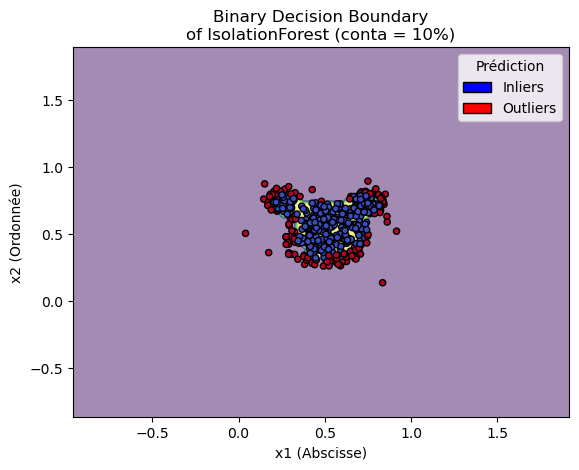

In [10]:
y_pred = mouse_data_1['anomaly'].replace({1: 0, -1: 1})  # 0 pour inliers, 1 pour outliers (pour le graphique)

# Visualisation des frontières de décision
disp = DecisionBoundaryDisplay.from_estimator(
    iso_forest_model,
    mouse_data_1[["x1", "x2"]],
    response_method="predict",
    alpha=0.5,
)
disp.ax_.scatter(mouse_data_1["x1"], mouse_data_1["x2"], c=y_pred, cmap="coolwarm", s=20, edgecolor="k")
disp.ax_.set_title("Binary Decision Boundary\nof IsolationForest (conta = 10%)")
disp.ax_.set_xlabel("x1 (Abscisse)")
disp.ax_.set_ylabel("x2 (Ordonnée)")
# plt.legend(["Inliers", "Outliers"], loc="upper right")

# Création d'une légende manuelle
legend_elements = [
    Patch(facecolor="blue", edgecolor="k", label="Inliers"),
    Patch(facecolor="red", edgecolor="k", label="Outliers"),
]
disp.ax_.legend(handles=legend_elements, loc="upper right", title="Prédiction")

#### 5. Amélioration du seuil de contamination

À propos de mouse.txt, on nous dit : 
>Ce fichier contient 500 instances décrites par deux variables x1 et x2 représentant des points de la tête de Mickey Mouse. Les 10 dernières instances du fichier sont aberrantes (outliers).

On a donc $\frac{10}{500}=2\%$ d'outliers

On peut donc modifier l'argument `contamination` de la fonction `IsolationForest()` lors de la construction du modèle, qui par défaut vaut 10%.

In [11]:
mouse_data_1_bis = pd.read_table("mouse.txt", sep=" ", names=['x1', 'x2'])

iso_forest_model_1_bis = IsolationForest(
    n_estimators=100, 
    max_samples='auto', 
    contamination=0.02, 
    max_features=1.0, 
    bootstrap=False, 
    n_jobs=None, 
    random_state=42, 
    verbose=True, 
    warm_start=False)

iso_forest_model_1_bis.fit(mouse_data_1_bis)

# Prédire les anomalies
mouse_data_1_bis['anomaly'] = iso_forest_model_1_bis.predict(mouse_data_1_bis)  # -1 pour outliers, 1 pour normales

# Séparer les points normaux des outliers
normals_1_bis = mouse_data_1_bis[mouse_data_1_bis['anomaly'] == 1]
outliers_1_bis = mouse_data_1_bis[mouse_data_1_bis['anomaly'] == -1]

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


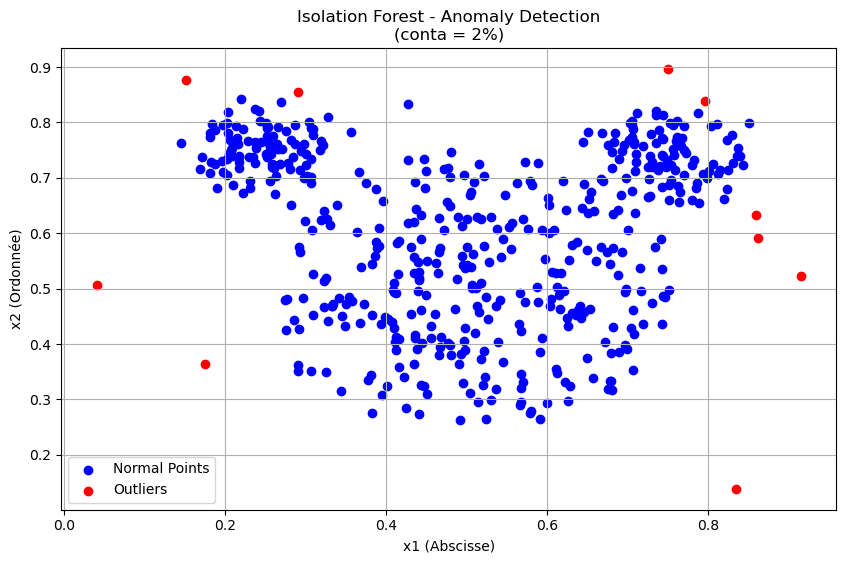

In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(normals_1_bis['x1'], normals_1_bis['x2'], color='blue', label='Normal Points')
plt.scatter(outliers_1_bis['x1'], outliers_1_bis['x2'], color='red', label='Outliers')
plt.xlabel('x1 (Abscisse)')
plt.ylabel('x2 (Ordonnée)')
plt.legend()
plt.title('Isolation Forest - Anomaly Detection\n(conta = 2%)')
plt.grid(True)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


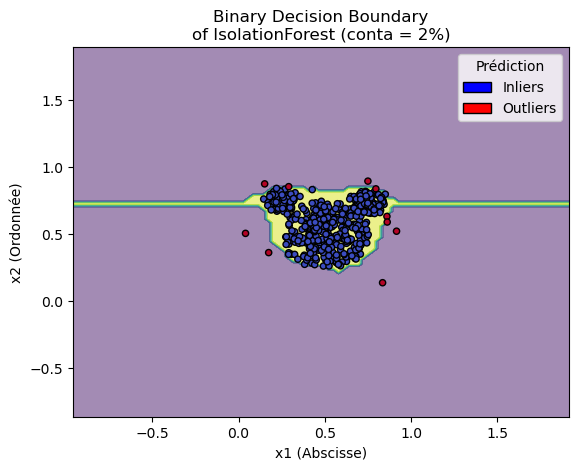

In [13]:
y_pred_1_bis = mouse_data_1_bis['anomaly'].replace({1: 0, -1: 1})  # 0 pour inliers, 1 pour outliers (pour le graphique)

# Visualisation des frontières de décision
disp_1_bis = DecisionBoundaryDisplay.from_estimator(
    iso_forest_model_1_bis,
    mouse_data_1_bis[["x1", "x2"]],
    response_method="predict",
    alpha=0.5,
)
disp_1_bis.ax_.scatter(mouse_data_1_bis["x1"], mouse_data_1_bis["x2"], c=y_pred_1_bis, cmap="coolwarm", s=20, edgecolor="k")
disp_1_bis.ax_.set_title("Binary Decision Boundary\nof IsolationForest (conta = 2%)")
disp_1_bis.ax_.set_xlabel("x1 (Abscisse)")
disp_1_bis.ax_.set_ylabel("x2 (Ordonnée)")
# plt.legend(["Inliers", "Outliers"], loc="upper right")

# Création d'une légende manuelle
legend_elements_1_bis = [
    Patch(facecolor="blue", edgecolor="k", label="Inliers"),
    Patch(facecolor="red", edgecolor="k", label="Outliers"),
]
disp_1_bis.ax_.legend(handles=legend_elements_1_bis, loc="upper right", title="Prédiction")

Essayons de représenter les scores prédit par Isolation Forest sous forme d'histogramme pour trouver un bon seuil de contamination

In [14]:
mouse_data_1_bis = pd.read_table("mouse.txt", sep=" ", names=['x1', 'x2'])

scores = iso_forest_model_1_bis.decision_function(mouse_data_1_bis)

plt.figure(figsize=(12, 8))
plt.hist(scores, bins=100);

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Contamination = 0.01


Contamination = 0.015


Contamination = 0.019999999999999997


Contamination = 0.024999999999999998


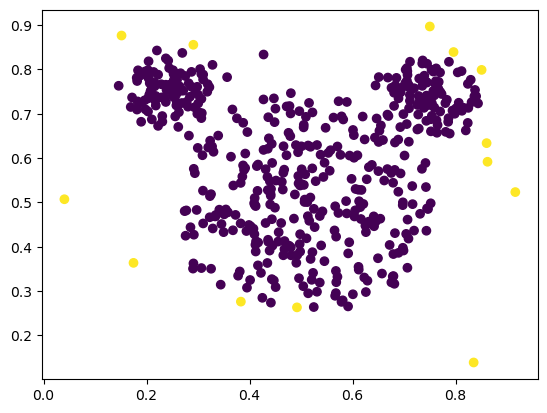

Contamination = 0.03


Contamination = 0.034999999999999996


Contamination = 0.039999999999999994


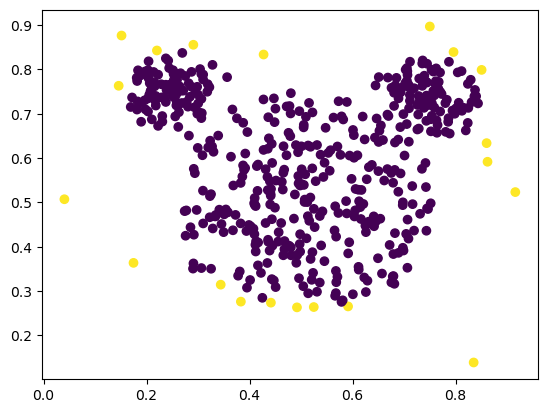

Contamination = 0.045


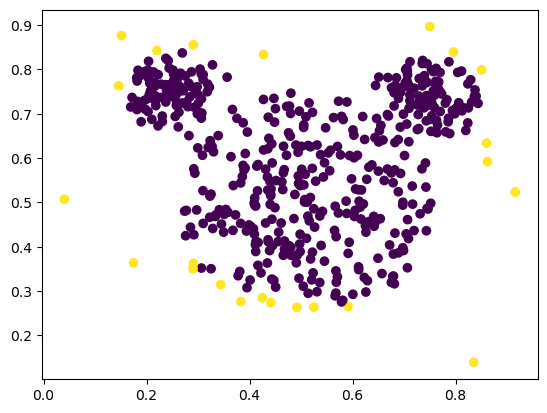

Contamination = 0.049999999999999996


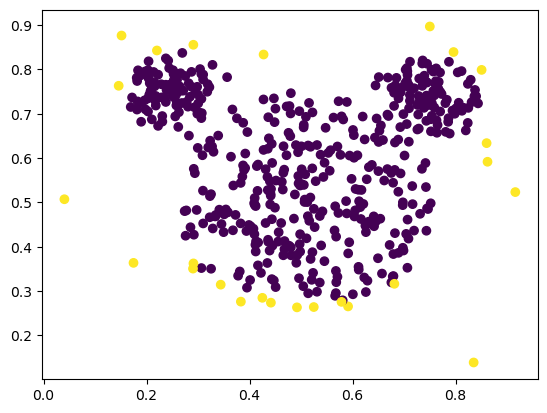

Contamination = 0.05499999999999999


Contamination = 0.05999999999999999


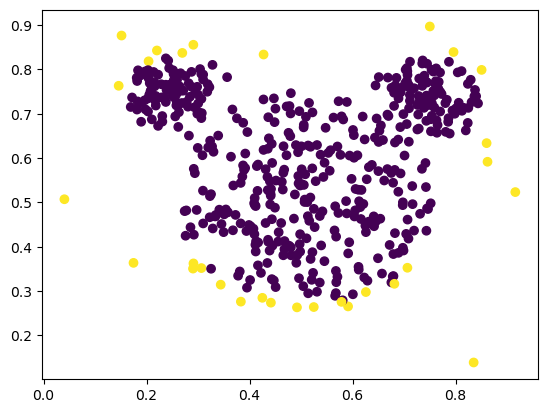

Contamination = 0.06499999999999999


Contamination = 0.06999999999999999


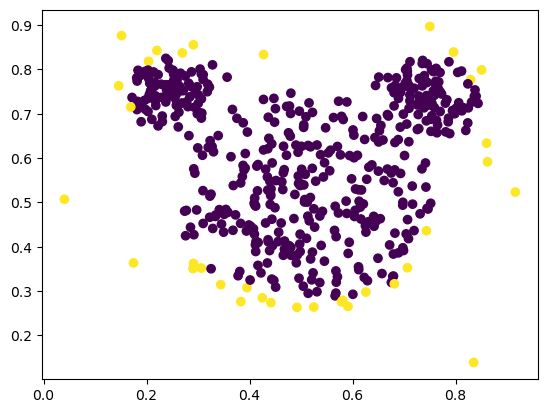

Contamination = 0.07499999999999998


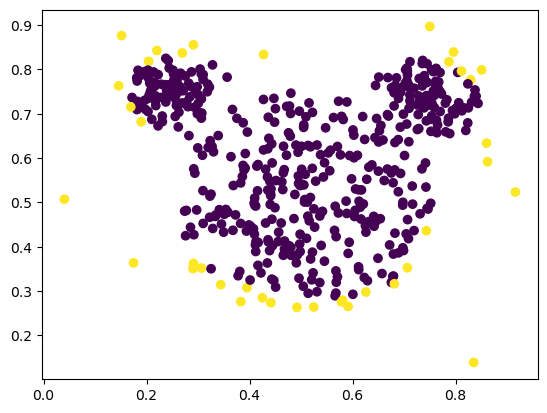

Contamination = 0.07999999999999999


Contamination = 0.08499999999999998


Contamination = 0.08999999999999998


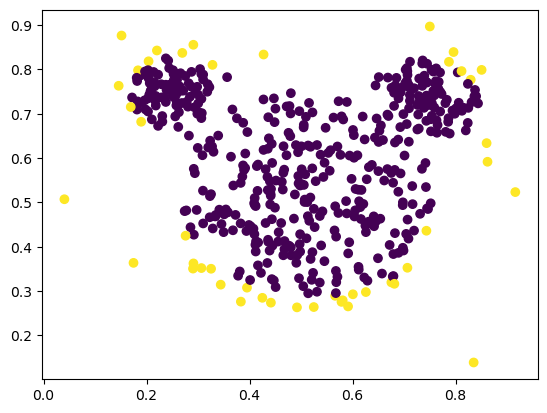

Contamination = 0.09499999999999999


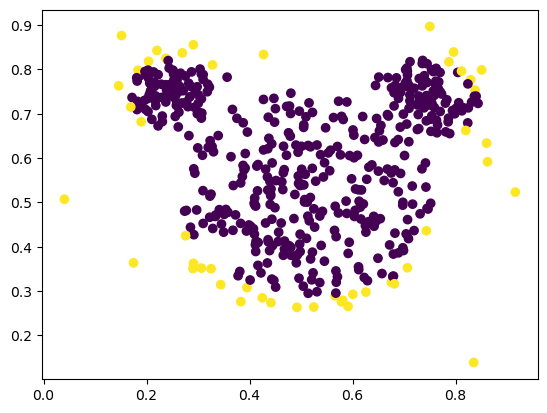

Contamination = 0.09999999999999998


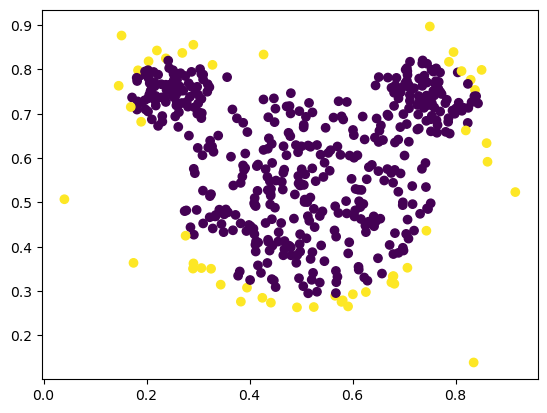

Contamination = 0.10499999999999998


Contamination = 0.10999999999999997


Contamination = 0.11499999999999998


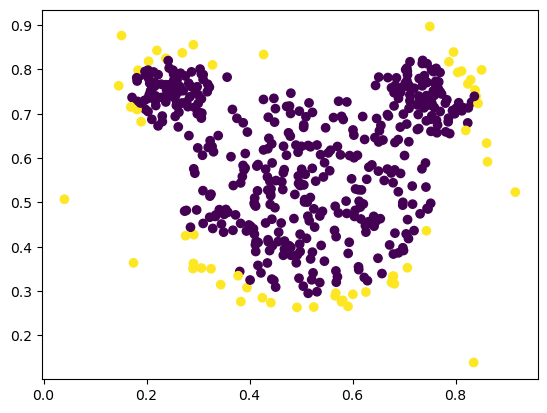

Contamination = 0.11999999999999998


Contamination = 0.12499999999999997


Contamination = 0.12999999999999998


Contamination = 0.13499999999999998


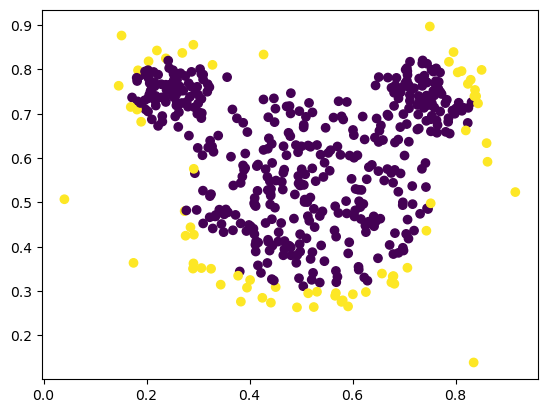

Contamination = 0.13999999999999999


Contamination = 0.145


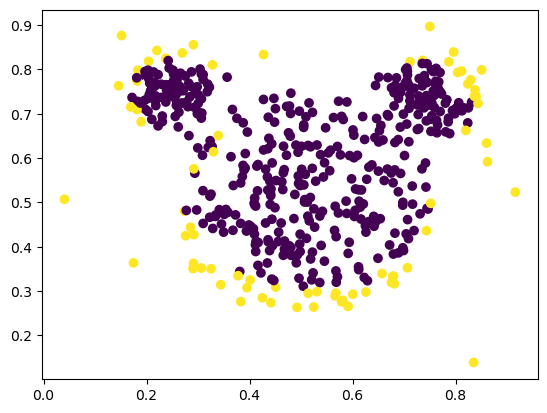

Contamination = 0.15


Contamination = 0.155


Contamination = 0.15999999999999998


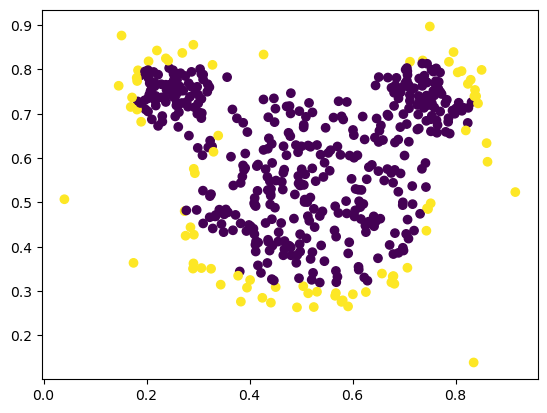

Contamination = 0.16499999999999998


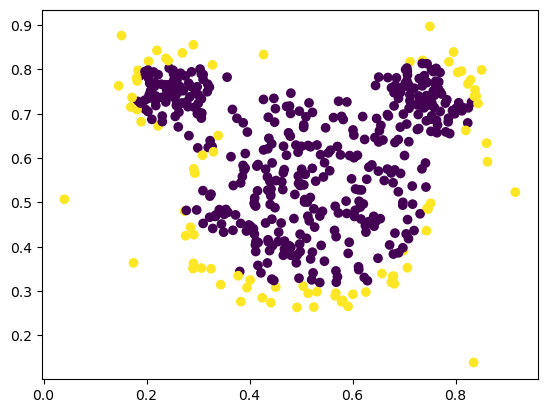

In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Charger les données une seule fois
mouse_data_1_bis_original = pd.read_table("mouse.txt", sep=" ", names=['x1', 'x2'])

# Boucle sur différentes valeurs de contamination
for i in np.arange(0.01, 0.17, 0.005):  # De 0.01 à 0.16 par pas de 0.01
    print(f"Contamination = {i}")

    # Créer une copie des données originales pour éviter de les modifier
    mouse_data_1_bis = mouse_data_1_bis_original.copy()

    # Configurer et entraîner le modèle Isolation Forest
    iso_forest_model_1_bis = IsolationForest(
        n_estimators=100, 
        max_samples='auto', 
        contamination=i, 
        max_features=1.0, 
        bootstrap=False, 
        random_state=42, 
        verbose=False, 
        warm_start=False)

    iso_forest_model_1_bis.fit(mouse_data_1_bis)

    # Calculer les scores de décision
    scores = iso_forest_model_1_bis.decision_function(mouse_data_1_bis)

    # Prédire les anomalies
    anomalies = iso_forest_model_1_bis.predict(mouse_data_1_bis)  # -1 pour outliers, 1 pour normales

    # Ajouter les anomalies dans un DataFrame séparé (si nécessaire)
    mouse_data_1_bis['anomaly'] = anomalies

    treshold = 0.0
    anomaly=scores.copy()
    anomaly[scores<=treshold]=1
    anomaly[scores>treshold]=0
    anomaly
    plt.scatter(mouse_data_1_bis.iloc[:, 0], mouse_data_1_bis.iloc[:, 1], c=anomaly, cmap=plt.get_cmap('viridis'))
    plt.show()



En fixant un seuil fixe et en faisant varier la contamination, on peut regarder visuellement si les points sont bel et bien outliers selon les différentes contaminations.

### D. Détection d'outlier par Local Outlier Factor (LOF)

#### 1. Modèle LOF avec contamination par défaut

##### a. Model training

In [16]:
mouse_data_lof_1 = pd.read_table("mouse.txt", sep=" ", names=['x1', 'x2'])

Lof_model_1 = LocalOutlierFactor(
    n_neighbors=20,
    algorithm='auto', 
    leaf_size=30, 
    metric='minkowski', 
    p=2, 
    metric_params=None, 
    contamination='auto', 
    novelty=False, 
    n_jobs=None)
    
y_pred_lof_1 = Lof_model_1.fit_predict(mouse_data_lof_1)
mouse_data_lof_1_scores = Lof_model_1.negative_outlier_factor_

##### b. Représentation graphique

Text(0.5, 1.0, 'Local Outlier Factor (LOF)\n(conta = 10%)')

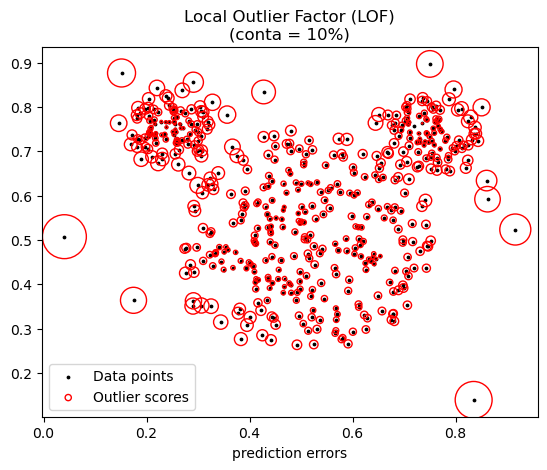

In [17]:
def update_legend_marker_size(handle, orig):
    "Customize size of the legend marker"
    handle.update_from(orig)
    handle.set_sizes([20])


plt.scatter(mouse_data_lof_1.iloc[:, 0], mouse_data_lof_1.iloc[:, 1], color="k", s=3.0, label="Data points")
# plot circles with radius proportional to the outlier scores
radius = (mouse_data_lof_1_scores.max() - mouse_data_lof_1_scores) / (mouse_data_lof_1_scores.max() - mouse_data_lof_1_scores.min())
scatter = plt.scatter(
    mouse_data_lof_1.iloc[:, 0],
    mouse_data_lof_1.iloc[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
plt.xlabel("prediction errors")
plt.legend(
    handler_map={scatter: HandlerPathCollection(update_func=update_legend_marker_size)}
)
plt.title("Local Outlier Factor (LOF)\n(conta = 10%)")

In [18]:
# def update_legend_marker_size(handle, orig):
#     """Customize size of the legend marker."""
#     handle.update_from(orig)
#     handle.set_sizes([20])

# # Normalisation des scores pour ajuster la taille des points
# radius = (mouse_data_lof_1_scores.max() - mouse_data_lof_1_scores) / (
#     mouse_data_lof_1_scores.max() - mouse_data_lof_1_scores.min()
# )

# # Points normaux
# plt.scatter(
#     mouse_data_lof_1.iloc[:, 0],
#     mouse_data_lof_1.iloc[:, 1],
#     color="k",
#     s=3.0,
#     label="Inliers"
# )

# # Points anormaux avec tailles proportionnelles aux scores
# scatter = plt.scatter(
#     mouse_data_lof_1.iloc[:, 0],
#     mouse_data_lof_1.iloc[:, 1],
#     c=radius,  # Utilisation de couleurs (peut aussi être "red" pour une seule couleur)
#     cmap="coolwarm",  # Palette pour représenter les scores
#     s=100 * radius,  # Taille proportionnelle aux scores
#     label="Outlier scores"
# )

# # Ajustements de l'affichage
# plt.axis("tight")
# plt.xlabel("Prediction errors")
# plt.colorbar(scatter, label="Normalized LOF Scores")  # Ajouter une barre de couleur
# plt.legend(
#     handler_map={scatter: HandlerPathCollection(update_func=update_legend_marker_size)}
# )
# plt.title("Local Outlier Factor (LOF)")
# plt.show()


#### 2. Modèle LOF avec contamination à 2%

##### a. Model training

In [19]:
mouse_data_lof_2 = pd.read_table("mouse.txt", sep=" ", names=['x1', 'x2'])

Lof_model_2 = LocalOutlierFactor(
    n_neighbors=20,
    algorithm='auto', 
    leaf_size=30, 
    metric='minkowski', 
    p=2, 
    metric_params=None, 
    contamination=0.02, 
    novelty=False, 
    n_jobs=None)
    
y_pred_lof_2 = Lof_model_2.fit_predict(mouse_data_lof_2)
mouse_data_lof_2_scores = Lof_model_2.negative_outlier_factor_

##### b. Représentation graphique

Text(0.5, 1.0, 'Local Outlier Factor (LOF)\n(conta = 2%)')

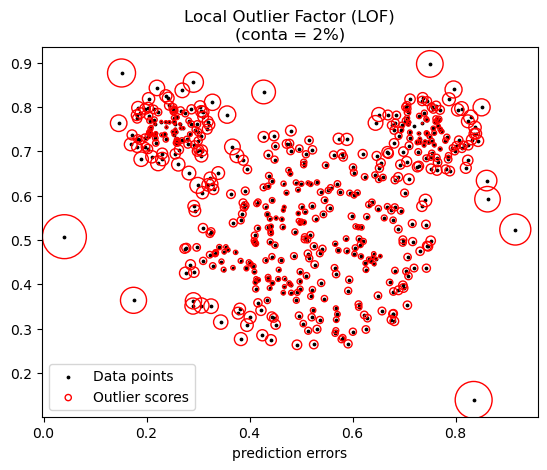

In [20]:
def update_legend_marker_size(handle, orig):
    "Customize size of the legend marker"
    handle.update_from(orig)
    handle.set_sizes([20])


plt.scatter(mouse_data_lof_2.iloc[:, 0], mouse_data_lof_2.iloc[:, 1], color="k", s=3.0, label="Data points")
# plot circles with radius proportional to the outlier scores
radius = (mouse_data_lof_2_scores.max() - mouse_data_lof_2_scores) / (mouse_data_lof_2_scores.max() - mouse_data_lof_2_scores.min())
scatter = plt.scatter(
    mouse_data_lof_2.iloc[:, 0],
    mouse_data_lof_2.iloc[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
plt.xlabel("prediction errors")
plt.legend(
    handler_map={scatter: HandlerPathCollection(update_func=update_legend_marker_size)}
)
plt.title("Local Outlier Factor (LOF)\n(conta = 2%)")

In [21]:
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection

# Créer une figure principale avec 2x2 sous-graphiques
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Figure 1 - Isolation Forest (conta = 10%)
axs[0, 0].scatter(normals['x1'], normals['x2'], color='blue', label='Normal Points')
axs[0, 0].scatter(outliers['x1'], outliers['x2'], color='red', label='Outliers')
axs[0, 0].set_xlabel('x1 (Abscisse)')
axs[0, 0].set_ylabel('x2 (Ordonnée)')
axs[0, 0].legend()
axs[0, 0].set_title('Isolation Forest - Anomaly Detection\n(conta = 10%)')
axs[0, 0].grid(True)

# Figure 2 - Isolation Forest (conta = 2%)
axs[0, 1].scatter(normals_1_bis['x1'], normals_1_bis['x2'], color='blue', label='Normal Points')
axs[0, 1].scatter(outliers_1_bis['x1'], outliers_1_bis['x2'], color='red', label='Outliers')
axs[0, 1].set_xlabel('x1 (Abscisse)')
axs[0, 1].set_ylabel('x2 (Ordonnée)')
axs[0, 1].legend()
axs[0, 1].set_title('Isolation Forest - Anomaly Detection\n(conta = 2%)')
axs[0, 1].grid(True)

# Figure 3 - Local Outlier Factor (conta = 10%)
radius = (mouse_data_lof_1_scores.max() - mouse_data_lof_1_scores) / (mouse_data_lof_1_scores.max() - mouse_data_lof_1_scores.min())
scatter = axs[1, 0].scatter(
    mouse_data_lof_1.iloc[:, 0],
    mouse_data_lof_1.iloc[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
axs[1, 0].scatter(mouse_data_lof_1.iloc[:, 0], mouse_data_lof_1.iloc[:, 1], color="k", s=3.0, label="Data points")
axs[1, 0].set_xlabel("prediction errors")
axs[1, 0].set_title("Local Outlier Factor (LOF)\n(conta = 10%)")
axs[1, 0].legend(
    handler_map={scatter: HandlerPathCollection(update_func=lambda h, o: h.update_from(o) or h.set_sizes([20]))}
)

# Figure 4 - Local Outlier Factor (conta = 2%)
radius = (mouse_data_lof_2_scores.max() - mouse_data_lof_2_scores) / (mouse_data_lof_2_scores.max() - mouse_data_lof_2_scores.min())
scatter = axs[1, 1].scatter(
    mouse_data_lof_2.iloc[:, 0],
    mouse_data_lof_2.iloc[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
axs[1, 1].scatter(mouse_data_lof_2.iloc[:, 0], mouse_data_lof_2.iloc[:, 1], color="k", s=3.0, label="Data points")
axs[1, 1].set_xlabel("prediction errors")
axs[1, 1].set_title("Local Outlier Factor (LOF)\n(conta = 2%)")
axs[1, 1].legend(
    handler_map={scatter: HandlerPathCollection(update_func=lambda h, o: h.update_from(o) or h.set_sizes([20]))}
)

# Ajuster les espaces entre les sous-graphes
fig.tight_layout()

Faire un histogramme des score prédit par isolation.forest_model.decision_fonction

---

## III. Détection de fraudes bancaires

### A. Data pre-processing

#### 1. Load data

In [4]:
df = taa.load_data("creditcard.csv", sep = ",")

            Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.462388  0.239599  0.098698  0.363787  ... -0.01830

#### 2. Data description 

In [5]:
taa.get_info(df)

### Infos générale ###

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null 

#### 3. Equilibre des classes

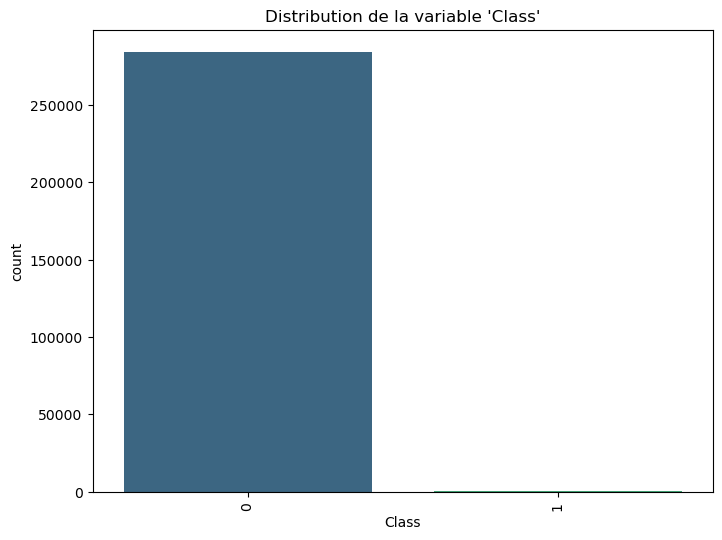


Comptage des occurrences des classes pour 'Class':

Class
0    284315
1       492
Name: count, dtype: int64

Pourcentage des classes pour 'Class':

Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64


In [6]:
taa.plot_class_distribution(df, 'Class')

Les données sont très déséquilibrés !!! (Une des classe est très très majoritaire comparé à l'autre)

#### 4. Supprimer la colonne Time

In [7]:
#La colonne Time n'est pas pertinente pour la détection des fraudes donc on la supprime :
df.drop(['Time'], axis=1, inplace=True)

#### 5. Split features and target

In [8]:
X, y = taa.split_feature_label(df, 'Class')

Les features sont dans le dataframe X (284807 lignes, 29 colonnes).
La target est dans la série y (284807 éléments).


#### 6. Split train/test and scale

Le jeu de donnée d'origine est très grand, on va donc faire, grace à StratifiedShuffleSplit, 3 echantillons pour faire des valisations croisées stratifiées.
On fait du Stratified car on a des classes très déséquilibrés

In [9]:
# Configurer StratifiedShuffleSplit
# n_splits=3 pour 3 splits, test_size=0.3 pour 30% des données de test, random_state=42 pour la reproductibilité
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=42)

print("Pourcentages dans les données originales :")
print(y.value_counts(normalize=True) * 100, '\n')

# Effectuer le split train / test
for fold, (train_index, test_index) in enumerate(sss.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print(f"--- Fold {fold + 1} ---")

    X_train_scaled, X_test_scaled = taa.scale_features(X_train, X_test, scaler_type="RobustScaler")
    print("Les données ont été splitées en ensembles d'entraînement et de test.")

    #Vérification des proportions des classes dans les ensembles créés :
    print("Pourcentages dans l'ensemble d'entraînement :")
    print("y_train :\n", y_train.value_counts(normalize=True) * 100)
    #print("X_train :\n", X_train.value_counts(normalize=True) * 100)
    print("Pourcentages dans l'ensemble de test :")
    print("y_test :\n", y_test.value_counts(normalize=True) * 100, '\n')
    #print("X_test :\n", X_test.value_counts(normalize=True) * 100)


Pourcentages dans les données originales :
Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64 

--- Fold 1 ---

Les features ont été mises à l'échelle avec RobustScaler.

Les données ont été splitées en ensembles d'entraînement et de test.
Pourcentages dans l'ensemble d'entraînement :
y_train :
 Class
0    99.827451
1     0.172549
Name: proportion, dtype: float64
Pourcentages dans l'ensemble de test :
y_test :
 Class
0    99.826785
1     0.173215
Name: proportion, dtype: float64 

--- Fold 2 ---

Les features ont été mises à l'échelle avec RobustScaler.

Les données ont été splitées en ensembles d'entraînement et de test.
Pourcentages dans l'ensemble d'entraînement :
y_train :
 Class
0    99.827451
1     0.172549
Name: proportion, dtype: float64
Pourcentages dans l'ensemble de test :
y_test :
 Class
0    99.826785
1     0.173215
Name: proportion, dtype: float64 

--- Fold 3 ---

Les features ont été mises à l'échelle avec RobustScaler.

Les données ont été splitées en

Les répartitions des classes dans les échantillons sont équivalentes

### B. Detection d'outliers

#### 1. Approches supervisées classiques

##### 1.1 Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Modèle
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

# Prédictions
y_pred_logreg = logreg.predict(X_test)

# Évaluation
print("Logistic Regression - Rapport de classification :")
print(classification_report(y_test, y_pred_logreg))

# Score ROC-AUC
roc_auc_logreg = roc_auc_score(y_test, y_pred_logreg)
print(f"ROC-AUC (Logistic Regression): {roc_auc_logreg:.3f}")


Logistic Regression - Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.86      0.69      0.77       148

    accuracy                           1.00     85443
   macro avg       0.93      0.84      0.88     85443
weighted avg       1.00      1.00      1.00     85443

ROC-AUC (Logistic Regression): 0.845


Precision :
- Proportion de transactions prédites comme frauduleuses qui sont effectivement frauduleuses
Recall (ou Sensibilité) : 
- Proportion de fraudes détectées parmi toutes les fraudes existantes

F1-score : 
- Moyenne harmonique de la précision et du rappel. Utile pour un compromis équilibré entre les deux

Support : 
- Nombre d'échantillons pour chaque classe (0 ou 1)

##### 1.2 Support vector machine (SVM)

In [ ]:
from sklearn.svm import SVC

# Modèle
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Prédictions
y_pred_svm = svm_model.predict(X_test)

# Évaluation
print("SVM - Rapport de classification :")
print(classification_report(y_test, y_pred_svm))

# Score ROC-AUC
roc_auc_svm = roc_auc_score(y_test, y_pred_svm)
print(f"ROC-AUC (SVM): {roc_auc_svm:.3f}")

Tourne à l'infini ???

##### 1.2 Random Forest sans pondération

In [16]:
from sklearn.ensemble import RandomForestClassifier

# Modèle
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Prédictions
y_pred_rf = rf_model.predict(X_test)

# Évaluation
print("Random Forest (Pondération) - Rapport de classification :")
print(classification_report(y_test, y_pred_rf))

# Score ROC-AUC
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)
print(f"ROC-AUC (Random Forest): {roc_auc_rf:.3f}")

Random Forest (Pondération) - Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.92      0.82      0.87       148

    accuracy                           1.00     85443
   macro avg       0.96      0.91      0.93     85443
weighted avg       1.00      1.00      1.00     85443

ROC-AUC (Random Forest): 0.909


#### 2. Approches supervisées adaptées au déséquilibre

##### 2.1 Random Forest avec pondération

In [11]:
from sklearn.ensemble import RandomForestClassifier

# Modèle
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# Prédictions
y_pred_rf = rf_model.predict(X_test)

# Évaluation
print("Random Forest (Pondération) - Rapport de classification :")
print(classification_report(y_test, y_pred_rf))

# Score ROC-AUC
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)
print(f"ROC-AUC (Random Forest): {roc_auc_rf:.3f}")


Random Forest (Pondération) - Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.96      0.80      0.88       148

    accuracy                           1.00     85443
   macro avg       0.98      0.90      0.94     85443
weighted avg       1.00      1.00      1.00     85443

ROC-AUC (Random Forest): 0.902


##### 2.2 XGBoost avec gestion du déséquilibre

In [12]:
from xgboost import XGBClassifier

# Modèle
xgb_model = XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), random_state=42)
xgb_model.fit(X_train, y_train)

# Prédictions
y_pred_xgb = xgb_model.predict(X_test)

# Évaluation
print("XGBoost - Rapport de classification :")
print(classification_report(y_test, y_pred_xgb))

# Score ROC-AUC
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb)
print(f"ROC-AUC (XGBoost): {roc_auc_xgb:.3f}")


XGBoost - Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.89      0.84      0.86       148

    accuracy                           1.00     85443
   macro avg       0.95      0.92      0.93     85443
weighted avg       1.00      1.00      1.00     85443

ROC-AUC (XGBoost): 0.919


##### 2.3 Balanced Bagging Classifier

In [13]:
from imblearn.ensemble import BalancedBaggingClassifier

# Modèle
bbc_model = BalancedBaggingClassifier(random_state=42)
bbc_model.fit(X_train, y_train)

# Prédictions
y_pred_bbc = bbc_model.predict(X_test)

# Évaluation
print("Balanced Bagging Classifier - Rapport de classification :")
print(classification_report(y_test, y_pred_bbc))

# Score ROC-AUC
roc_auc_bbc = roc_auc_score(y_test, y_pred_bbc)
print(f"ROC-AUC (Balanced Bagging Classifier): {roc_auc_bbc:.3f}")


Balanced Bagging Classifier - Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85295
           1       0.05      0.92      0.10       148

    accuracy                           0.97     85443
   macro avg       0.53      0.95      0.54     85443
weighted avg       1.00      0.97      0.98     85443

ROC-AUC (Balanced Bagging Classifier): 0.945


#### 3. Approches non supervisées

##### 3.1 Isolation Forest

In [14]:
from sklearn.ensemble import IsolationForest

# Modèle Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.001, random_state=42)
iso_forest.fit(X_train)

# Scores d'anomalie et prédictions
scores_iso = iso_forest.decision_function(X_test)
y_pred_iso = [1 if score < 0 else 0 for score in scores_iso]

# Évaluation
print("Isolation Forest - Rapport de classification :")
print(classification_report(y_test, y_pred_iso))

# Score ROC-AUC
roc_auc_iso = roc_auc_score(y_test, y_pred_iso)
print(f"ROC-AUC (Isolation Forest): {roc_auc_iso:.3f}")


Isolation Forest - Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.28      0.20      0.23       148

    accuracy                           1.00     85443
   macro avg       0.64      0.60      0.61     85443
weighted avg       1.00      1.00      1.00     85443

ROC-AUC (Isolation Forest): 0.598


##### 3.2 Local Outlier Factor (LOF)

In [15]:
from sklearn.neighbors import LocalOutlierFactor

# Modèle LOF
lof_model = LocalOutlierFactor(n_neighbors=20, contamination=0.001, novelty=True)
lof_model.fit(X_train)

# Scores d'anomalie et prédictions
scores_lof = lof_model.decision_function(X_test)
y_pred_lof = [1 if score < 0 else 0 for score in scores_lof]

# Évaluation
print("Local Outlier Factor - Rapport de classification :")
print(classification_report(y_test, y_pred_lof))

# Score ROC-AUC
roc_auc_lof = roc_auc_score(y_test, y_pred_lof)
print(f"ROC-AUC (LOF): {roc_auc_lof:.3f}")


Local Outlier Factor - Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.00      0.00      0.00       148

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

ROC-AUC (LOF): 0.500


#### 4. Visualisation et comparaison

##### 4.1 Courbes ROC

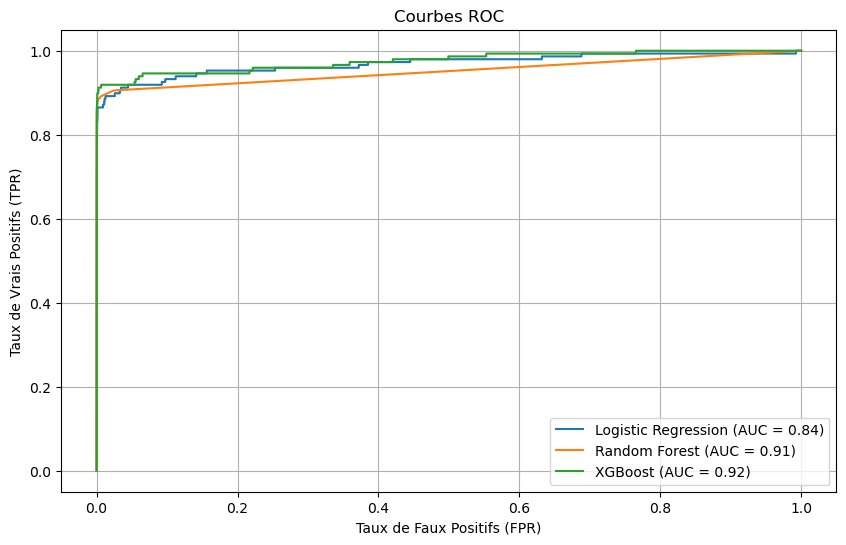

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcul des courbes ROC
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg.predict_proba(X_test)[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])

# Affichage des courbes ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr_logreg, tpr_logreg, label=f"Logistic Regression (AUC = {roc_auc_logreg:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.2f})")
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.title("Courbes ROC")
plt.legend()
plt.grid()
plt.show()


Évalue la capacité du modèle à discriminer les classes (fraudes et non-fraudes)


Diagonale (ligne rouge) : 
- Modèle aléatoire
    - Plus la courbe s'éloigne de cette diagonale vers le coin supérieur gauche, meilleur est le modèle

AUC-ROC (Area Under the Curve) :
- Représente la performance globale
    - 1.0 : Modèle parfait
    - 0.5 : Modèle aléatoire
    - Entre 0.5 et 1.0
        - Plus la valeur est élevée, meilleure est la discrimination entre les classes

La régression logistique a une AUC-ROC de 0.98 contre 0.96 pour le Random Forest, La régression logistique est donc légèrement meilleur pour classer les transactions

##### 4.2 Courbes Précision/Rappel

In [18]:
from sklearn.metrics import precision_recall_curve

# Calcul des courbes Precision/Rappel
prec_logreg, recall_logreg, _ = precision_recall_curve(y_test, logreg.predict_proba(X_test)[:, 1])
prec_rf, recall_rf, _ = precision_recall_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
prec_xgb, recall_xgb, _ = precision_recall_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])

# Affichage des courbes Precision/Rappel
plt.figure(figsize=(10, 6))
plt.plot(recall_logreg, prec_logreg, label="Logistic Regression")
plt.plot(recall_rf, prec_rf, label="Random Forest")
plt.plot(recall_xgb, prec_xgb, label="XGBoost")
plt.xlabel("Rappel")
plt.ylabel("Précision")
plt.title("Courbes Precision/Rappel")
plt.legend()
plt.grid()
plt.show()


Axe X (Recall) : 
- Fraction des fraudes détectées parmi toutes les fraudes (même que dans la courbe ROC).

Axe Y (Precision) :
- Fraction des transactions prédites comme fraudes qui sont réellement frauduleuses.

Courbe ascendante (meilleur modèle) :
- Le modèle maintient une précision élevée tout en augmentant le rappel.

AUC Precision-Recall :
- Mesure la qualité du modèle sur des données déséquilibrées
    - Plus l'aire sous la courbe PR est grande, mieux le modèle détecte les fraudes tout en maintenant peu de faux positifs.

#### 5. Optimisation des hyperparamètres 

##### 5.1 Pour Isolation Forest

In [23]:
# Execution et selection des meilleurs paramètres

param_grid = {
    'n_estimators': [50, 100, 150],
    'contamination': [0.001, 0.005, 0.01]
}

results_iforest = taa.tune_isolation_forest(X_train, X_test, y_test, param_grid['n_estimators'], param_grid['contamination'])
best_params_iforest = results_iforest.loc[results_iforest['roc_auc'].idxmax()]
print("Meilleurs paramètres pour Isolation Forest :", best_params_iforest)


Meilleurs paramètres pour Isolation Forest : n_estimators     100.000000
contamination      0.010000
roc_auc            0.765563
pr_auc             0.000877
Name: 5, dtype: float64


##### 5.2 Pour LOF

In [24]:
# execution et sélection des meilleurs paramètres 

param_grid_lof = {'n_neighbors': [5, 10, 20, 30]}

results_lof = taa.tune_lof(X_train, X_test, y_test, param_grid_lof['n_neighbors'])
best_params_lof = results_lof.loc[results_lof['roc_auc'].idxmax()]
print("Meilleurs paramètres pour LOF :", best_params_lof)


Meilleurs paramètres pour LOF : n_neighbors    30.000000
roc_auc         0.693282
pr_auc          0.001104
Name: 3, dtype: float64


---
## III. Détection d’intrusions dans les réseaux


### A. Pre-processing

#### 1. Chargements des données

In [29]:
df = taa.load_data('KFFCup99.zip', sep=',')

        duration protocol_type service flag  src_bytes  dst_bytes  land  \
0              0           tcp    http   SF        181       5450     0   
1              0           tcp    http   SF        239        486     0   
2              0           tcp    http   SF        235       1337     0   
3              0           tcp    http   SF        219       1337     0   
4              0           tcp    http   SF        217       2032     0   
...          ...           ...     ...  ...        ...        ...   ...   
494015         0           tcp    http   SF        310       1881     0   
494016         0           tcp    http   SF        282       2286     0   
494017         0           tcp    http   SF        203       1200     0   
494018         0           tcp    http   SF        291       1200     0   
494019         0           tcp    http   SF        219       1234     0   

        wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0                    0       0    0

#### 2. Comprendre les données

In [30]:
taa.get_info(df)

### Infos générale ###

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494020 entries, 0 to 494019
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494020 non-null  int64  
 1   protocol_type                494020 non-null  object 
 2   service                      494020 non-null  object 
 3   flag                         494020 non-null  object 
 4   src_bytes                    494020 non-null  int64  
 5   dst_bytes                    494020 non-null  int64  
 6   land                         494020 non-null  int64  
 7   wrong_fragment               494020 non-null  int64  
 8   urgent                       494020 non-null  int64  
 9   hot                          494020 non-null  int64  
 10  num_failed_logins            494020 non-null  int64  
 11  logged_in                    494020 non-null  int64  
 12  lnum_compromised             49402

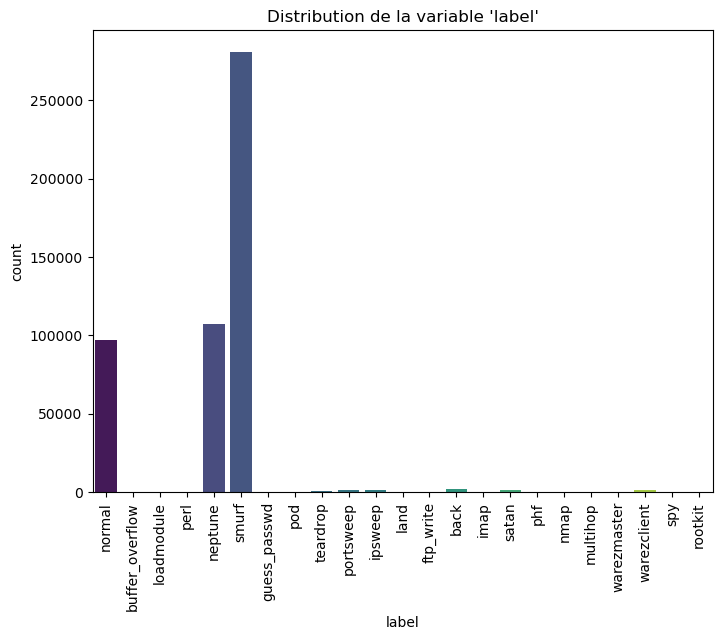


Comptage des occurrences des classes pour 'label':

label
smurf              280790
neptune            107201
normal              97277
back                 2203
satan                1589
ipsweep              1247
portsweep            1040
warezclient          1020
teardrop              979
pod                   264
nmap                  231
guess_passwd           53
buffer_overflow        30
land                   21
warezmaster            20
imap                   12
rootkit                10
loadmodule              9
ftp_write               8
multihop                7
phf                     4
perl                    3
spy                     2
Name: count, dtype: int64

Pourcentage des classes pour 'label':

label
smurf              56.837780
neptune            21.699729
normal             19.690903
back                0.445933
satan               0.321647
ipsweep             0.252419
portsweep           0.210518
warezclient         0.206469
teardrop            0.198170
pod       

In [31]:
taa.plot_class_distribution(df, 'label')

Les classes des labels sont assez déséquilibrés --> Il faudra donc une méthode de split stratifiée pour conserver les proportions de chaque classe

#### 3. On supprime les lignes avec des NA

In [32]:
df = taa.dropna(df)


Le dataset contenanait 0 valeurs manquantes avant l'opération.


Le dataset contient maintenant 0 valeurs manquantes.

Les valeurs manquantes ont été supprimées.


#### 4. Encoder les colonnes catégorielles

In [33]:
df, encode_dict = taa.encode_categorical(df)

Label encoding for column 'protocol_type':
  icmp: 0
  tcp: 1
  udp: 2


Label encoding for column 'service':
  IRC: 0
  X11: 1
  Z39_50: 2
  auth: 3
  bgp: 4
  courier: 5
  csnet_ns: 6
  ctf: 7
  daytime: 8
  discard: 9
  domain: 10
  domain_u: 11
  echo: 12
  eco_i: 13
  ecr_i: 14
  efs: 15
  exec: 16
  finger: 17
  ftp: 18
  ftp_data: 19
  gopher: 20
  hostnames: 21
  http: 22
  http_443: 23
  imap4: 24
  iso_tsap: 25
  klogin: 26
  kshell: 27
  ldap: 28
  link: 29
  login: 30
  mtp: 31
  name: 32
  netbios_dgm: 33
  netbios_ns: 34
  netbios_ssn: 35
  netstat: 36
  nnsp: 37
  nntp: 38
  ntp_u: 39
  other: 40
  pm_dump: 41
  pop_2: 42
  pop_3: 43
  printer: 44
  private: 45
  red_i: 46
  remote_job: 47
  rje: 48
  shell: 49
  smtp: 50
  sql_net: 51
  ssh: 52
  sunrpc: 53
  supdup: 54
  systat: 55
  telnet: 56
  tftp_u: 57
  tim_i: 58
  time: 59
  urh_i: 60
  urp_i: 61
  uucp: 62
  uucp_path: 63
  vmnet: 64
  whois: 65


Label encoding for column 'flag':
  OTH: 0
  REJ: 1
  RSTO: 2
  

#### 5. Définir les features et les labels

In [34]:
X, y = taa.split_feature_label(df, 'label')

Les features sont dans le dataframe X (494020 lignes, 41 colonnes).
La target est dans la série y (494020 éléments).


#### 6. Définir le train et le test

In [35]:
pipeline = Pipeline([
    ('scaling', RobustScaler()),
    ('modeling', RandomForestClassifier())
])

skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

NameError: name 'Pipeline' is not defined

OU

In [13]:
splitter = taa.choose_splitter_train_test('stratified_kfold', X, y, n_splits=3, test_size=0.2, random_state=42)

Le dataset sera divisé en training et testing sets en utilisant 'stratified_kfold'.


OU

In [9]:
split = taa.split_train_test(X, y, method='stratified_kfold' ,test_size=0.2, random_state=42, n_splits=3)

Le dataset a bien été divisé en 3 folds, avec pour chaque fold, X_train, X_test, y_train, y_test.
split[0], split[1], split[2], split[3] are folds
split[0][0] is the X_train set of the first fold,
split[0][1] is the X_test set of the first fold,
split[0][2] is the y_train set of the first fold,
split[0][3] is the y_test set of the first fold
etc...


#### 7. Scale les features

In [14]:
scaler = taa.choose_scaler('RobustScaler')

Le type de scaler choisis est RobustScaler.
Les données n'ont pas encore été scalées mais le scaler RobustScaler est prêt à être utilisé dans la pipeline.


OU

In [233]:
for fold, (X_train, X_test, y_train, y_test) in enumerate(split):
    X_train_scaled, X_test_scaled = taa.scale_features(X_train, X_test, scaler_type='RobustScaler')


"""
A completer
"""


Les features ont été mises à l'échelle avec RobustScaler.


### B. Run model

In [15]:
model = taa.choose_model('RandomForestClassifier')

Le modèle choisi est RandomForestClassifier.
Les données n'ont pas encore été procéssées mais le modèle RandomForestClassifier est prêt à être utilisé dans la pipeline.


In [27]:
results = taa.process_and_evaluate(X, y, scaler_type='RobustScaler', model_type='RandomForestClassifier', n_splits=5)


Résultats de la validation croisée :
Score moyen accuracy : 0.9997692401117364
Score moyen f1 : nan
Score moyen precision : nan
Score moyen recall : nan
Score moyen roc_auc : nan


OU

In [11]:
# Modèle à utiliser
model = RandomForestClassifier()

scores = []

# Validation croisée
for fold, (X_train, X_test, y_train, y_test) in enumerate(split):

    # Entraînement
    model.fit(X_train, y_train)

    # Prédiction et évaluation
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    scores.append(accuracy)

    print(f"Fold {fold + 1}: Accuracy = {accuracy:.4f}")

# Résultats globaux
print(f"Mean Accuracy: {sum(scores) / len(scores):.4f}")

Fold 1: Accuracy = 0.9998
Fold 2: Accuracy = 0.9997
Fold 3: Accuracy = 0.9997
Mean Accuracy: 0.9998


---

# IV. Détection de nouveautés

Objectif : Détecter des anomalies dans de nouvelles données non vues.

Méthodologie :

    Approches :
        Isolation Forest : Entraînez le modèle sur l’ensemble d’entraînement, puis utilisez-le pour prédire les anomalies sur un ensemble de test non étiqueté.
        LOF : Utilisez le paramètre novelty=True pour qu’il fonctionne sur des nouvelles données.

    Évaluation :
        Réutilisez les fonctions d’évaluation pour mesurer les scores ROC-AUC et PR-AUC.

##### A. Exemple avec Isolation Forest 

In [ ]:
iso_forest_novelty = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
iso_forest_novelty.fit(X_train)

# Prédictions sur un ensemble de nouvelles données
scores_novelty = iso_forest_novelty.decision_function(X_test)
y_pred_novelty = [1 if score < 0 else 0 for score in scores_novelty]

# Évaluation
roc_auc_novelty = roc_auc_score(y_test, y_pred_novelty)
print(f"ROC-AUC (Isolation Forest - Novelty): {roc_auc_novelty:.3f}")


##### B. Exemple avec LOF

In [ ]:
lof_novelty = LocalOutlierFactor(n_neighbors=20, novelty=True)
lof_novelty.fit(X_train)

# Prédictions sur un ensemble de nouvelles données
scores_lof_novelty = lof_novelty.decision_function(X_test)
y_pred_lof_novelty = [1 if score < 0 else 0 for score in scores_lof_novelty]

# Évaluation
roc_auc_lof_novelty = roc_auc_score(y_test, y_pred_lof_novelty)
print(f"ROC-AUC (LOF - Novelty): {roc_auc_lof_novelty:.3f}")


# Annexes (à enlever du rendu)

## Test fraudes bancaire avec méthodes d'over, under, hybrid sampling

#### 1. Régression Logistique & Random Forest Vs Over-sampling & Under-sampling & Hybrid-sampling

##### a. Entrainement des modèles supervisées classiques

On va comparer :
- Les approches supervisées classiques :
    - Régression Logistique
    - Random Forest 
- Les approches gérant le déséquilibre dans les données en amont :
    - Over-sampling (SMOTE) + Régression Logistique ou Random Forest
    - Under-sampling + Régression Logistique ou Random Forest
    - Hybrid-sampling + Régression Logistique ou Random Forest

In [ ]:
# Approche supervisée classique : Régression Logistique
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

# Approche supervisée classique : Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


KeyboardInterrupt: 

##### b. Métriques des modèles supervisées classiques

In [ ]:
print("Régression Logistique :")
print(classification_report(y_test, y_pred_logreg))

print("Random Forest :")
print(classification_report(y_test, y_pred_rf))

Régression Logistique :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.87      0.64      0.73       148

    accuracy                           1.00     85443
   macro avg       0.93      0.82      0.87     85443
weighted avg       1.00      1.00      1.00     85443

Random Forest :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.95      0.82      0.88       148

    accuracy                           1.00     85443
   macro avg       0.98      0.91      0.94     85443
weighted avg       1.00      1.00      1.00     85443



##### c. Courbes ROC des modèles supervisées classiques

In [ ]:
# Probabilités pour ROC
y_prob_logreg = logreg.predict_proba(X_test)[:, 1]
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Courbe ROC pour Régression Logistique
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_prob_logreg)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

# Courbe ROC pour Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Afficher la courbe ROC
plt.figure()
plt.plot(fpr_logreg, tpr_logreg, color='blue', label=f"Logistic Regression (AUC = {roc_auc_logreg:.2f})")
plt.plot(fpr_rf, tpr_rf, color='green', label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonale aléatoire
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

##### d. Courbe Precision-Recall des modèles supervisées classiques

In [ ]:
# Courbe Precision-Recall pour Régression Logistique
precision_logreg, recall_logreg, _ = precision_recall_curve(y_test, y_prob_logreg)

# Courbe Precision-Recall pour Random Forest
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_prob_rf)

# Afficher la courbe Precision-Recall
plt.figure()
plt.plot(recall_logreg, precision_logreg, color='blue', label="Logistic Regression")
plt.plot(recall_rf, precision_rf, color='green', label="Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

##### f. Entrainement des modèles mais avec rééquilibrage des classes au préalable

Réentrainons les modèles mais avec un prétraitement Over-sampling SMOTE sur le jeu de donnée

In [ ]:
# Vérifier la répartition avant équilibrage
print("Avant SMOTE, y_train distribution :", Counter(y_train))

# Appliquer SMOTE sur l'ensemble d'entraînement
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Vérifier la répartition après SMOTE
print("Après SMOTE, y_train distribution :", Counter(y_train_smote))

Avant SMOTE, y_train distribution : Counter({0: 199020, 1: 344})
Après SMOTE, y_train distribution : Counter({0: 199020, 1: 199020})


Les 2 classes sont maintenant bien équilibrés avec une sur représentation de la classe 1 pour compenser. Entrainons maintenant les modèles Random Forest et LOgistique regression sur ces nouvelles données de train

--- Logistic Regression ---
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85295
           1       0.06      0.93      0.11       148

    accuracy                           0.97     85443
   macro avg       0.53      0.95      0.55     85443
weighted avg       1.00      0.97      0.99     85443

AUC-ROC: 0.9816


--- Random Forest ---
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.91      0.85      0.88       148

    accuracy                           1.00     85443
   macro avg       0.95      0.93      0.94     85443
weighted avg       1.00      1.00      1.00     85443

AUC-ROC: 0.9668


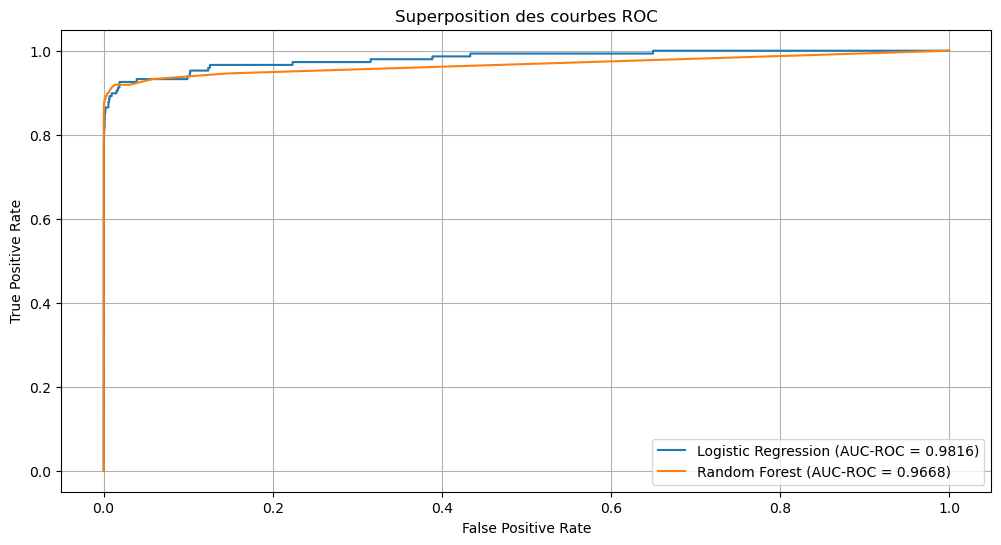

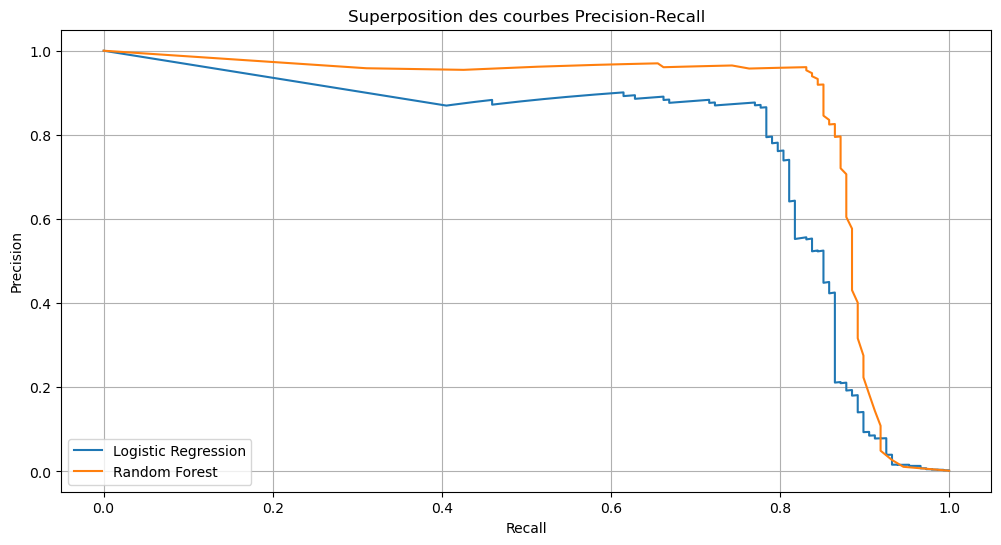

{'Logistic Regression': {'AUC-ROC': np.float64(0.9815543194287553)},
 'Random Forest': {'AUC-ROC': np.float64(0.96676035317808)}}

In [ ]:
run_pipeline(X_train_smote, y_train_smote, X_test, y_test, {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier()
})

Réentrainons les modèles mais avec un prétraitement Under-sampling sur le jeu de donnée

In [ ]:
# Vérifier la répartition avant équilibrage
print("Avant under-sampling, y_train distribution :", Counter(y_train))

# Appliquer l'under-sampling sur l'ensemble d'entraînement
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_undersampled, y_train_undersampled = under_sampler.fit_resample(X_train, y_train)

# Vérifier la répartition après RandomUnderSampler
print("Après under-sampling, y_train distribution :", Counter(y_train_undersampled), '\n')

Avant under-sampling, y_train distribution : Counter({0: 199020, 1: 344})
Après under-sampling, y_train distribution : Counter({0: 344, 1: 344})


Les 2 classes sont maintenant bien équilibrés avec une sous représentation de la classe 0 pour compenser. Entrainons maintenant les modèles Random Forest et LOgistique regression sur ces nouvelles données de train

In [ ]:
run_pipeline(X_train_undersampled, y_train_undersampled, X_test, y_test, {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier()
})

TypeError: run_pipeline() missing 1 required positional argument: 'models'

Les précisions ne sont vraiment pas bonnes avec l'under-sampling !!!

Réentrainons les modèles mais avec un prétraitement Hybride-sampling sur le jeu de donnée

In [ ]:
# Vérifier la répartition avant équilibrage
print("Avant hybrid-sampling, y_train distribution :", Counter(y_train))

# Appliquer l'échantillonnage hybride SMOTE-ENN
smote_enn = SMOTEENN(sampling_strategy='auto', random_state=42)
X_train_hybridsampled, y_train_hybridsampled = smote_enn.fit_resample(X_train, y_train)

# Vérifier la répartition après hybride SMOTE-ENN
print("Après hybrid-sampling, y_train distribution :", Counter(y_train_hybridsampled))

Avant hybrid-sampling, y_train distribution : Counter({0: 199020, 1: 344})
Après hybrid-sampling, y_train distribution : Counter({1: 199020, 0: 198666})


Les 2 classes sont maintenant presque bien équilibrés, on a un bon compromis entre les 2 classes. Entrainons maintenant les modèles Random Forest et LOgistique regression sur ces nouvelles données de train

--- Logistic Regression ---
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85295
           1       0.06      0.93      0.11       148

    accuracy                           0.97     85443
   macro avg       0.53      0.95      0.55     85443
weighted avg       1.00      0.97      0.99     85443

AUC-ROC: 0.9819


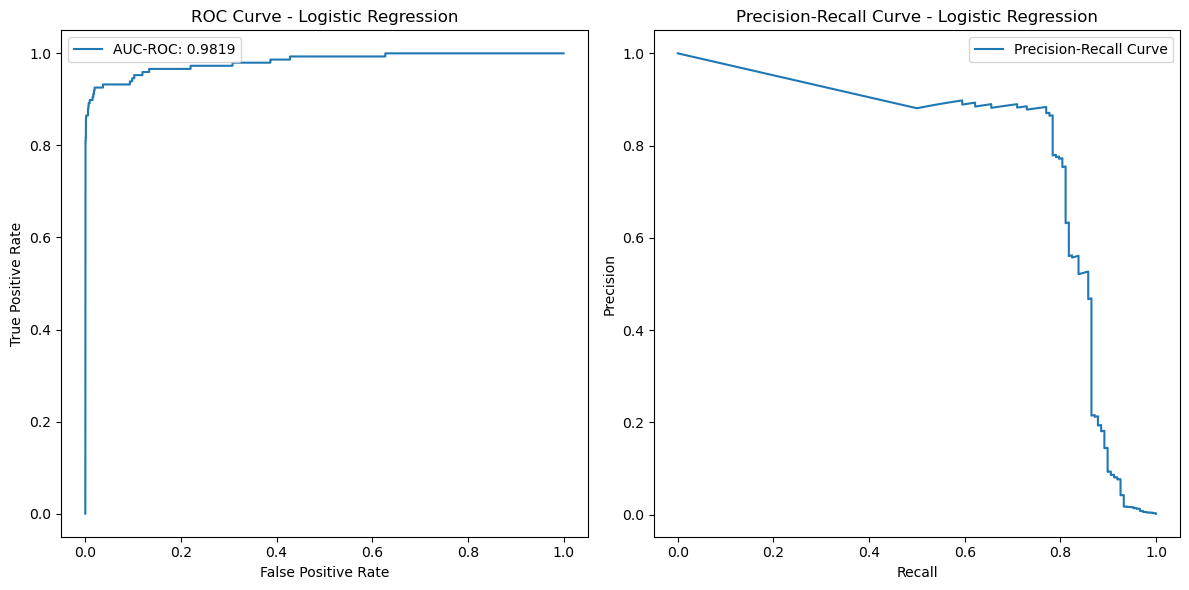

--- Random Forest ---
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.83      0.84      0.84       148

    accuracy                           1.00     85443
   macro avg       0.92      0.92      0.92     85443
weighted avg       1.00      1.00      1.00     85443

AUC-ROC: 0.9763


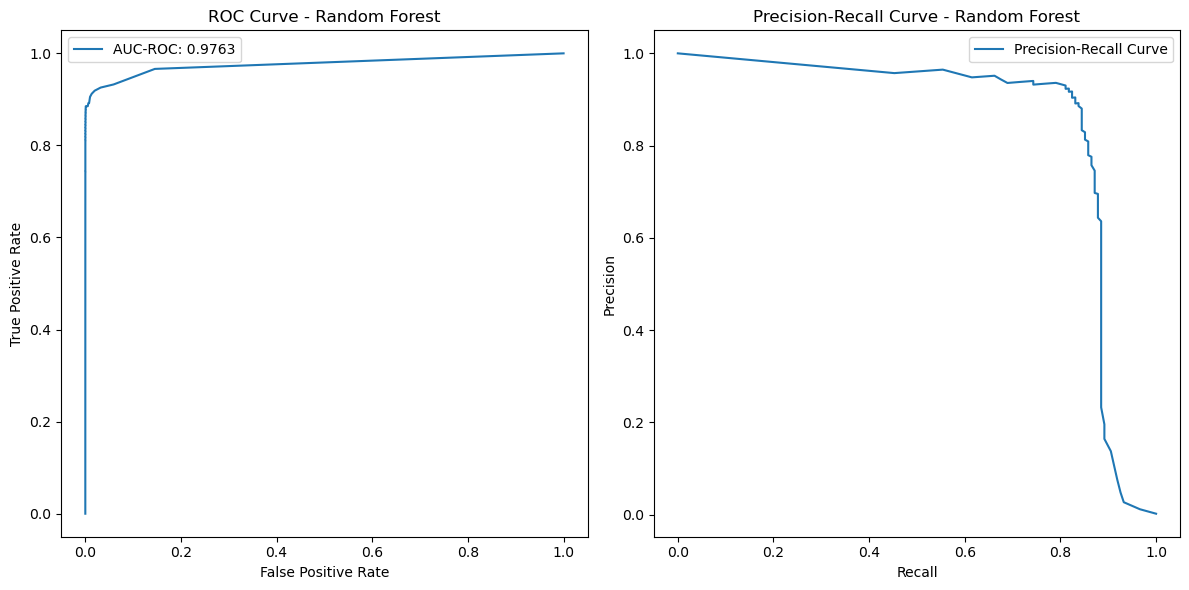

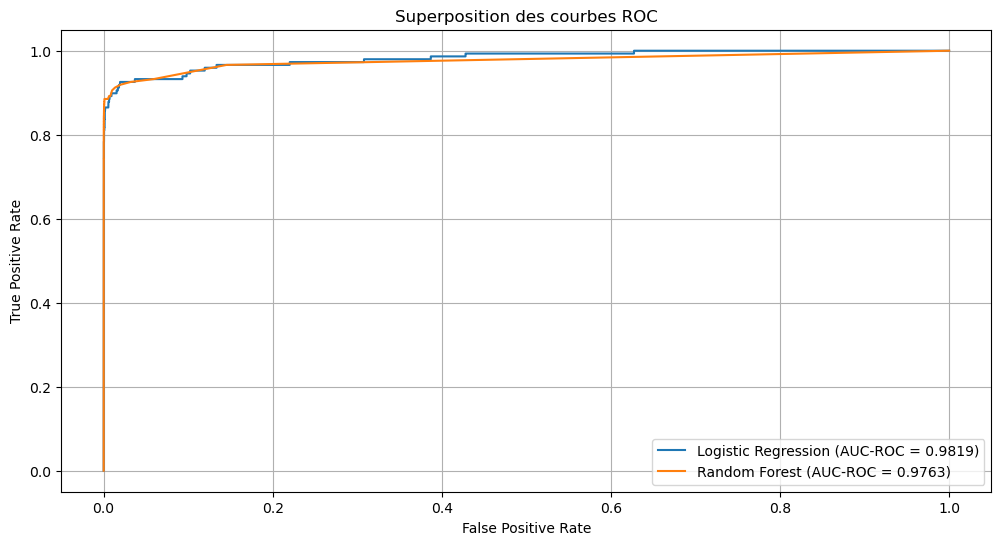

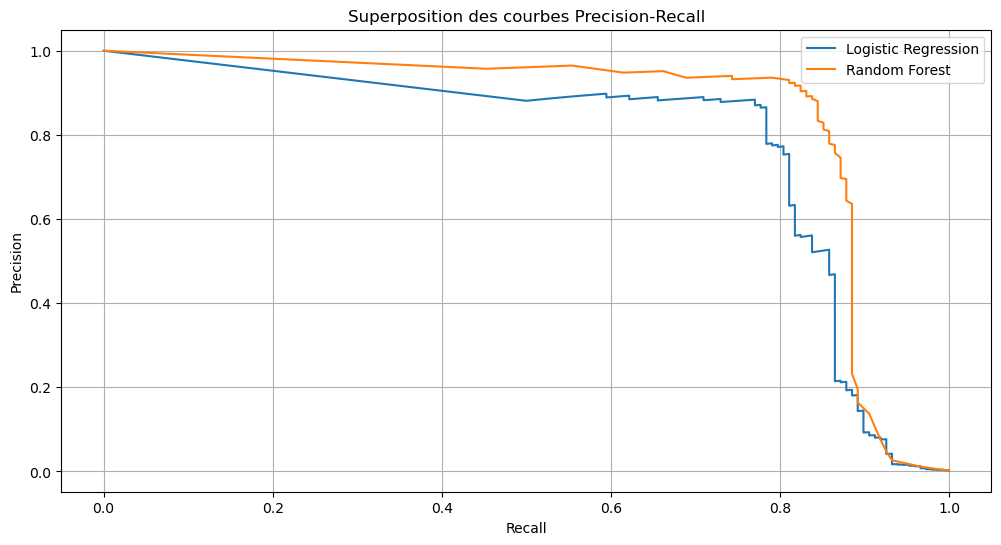

{'Logistic Regression': {'AUC-ROC': np.float64(0.9818994649729159)},
 'Random Forest': {'AUC-ROC': np.float64(0.9763109114155484)}}

In [ ]:
run_pipeline(X_train_hybridsampled, y_train_hybridsampled, X_test, y_test, {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier()
})

--- over_sampling ---
Avant échantillonnage, y_train distribution : Counter({0: 199020, 1: 344})
Après over_sampling, y_train distribution : Counter({0: 199020, 1: 199020}) 

--- Logistic Regression ---


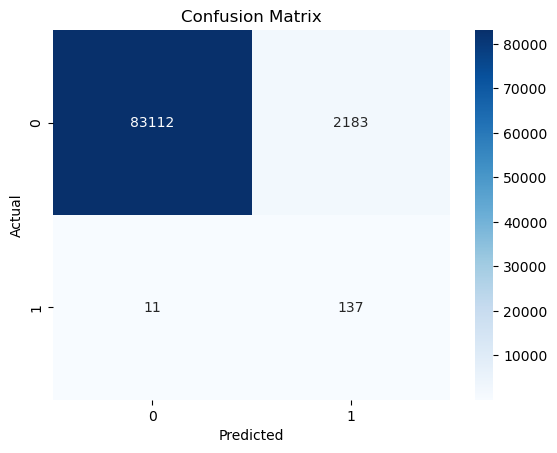

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85295
           1       0.06      0.93      0.11       148

    accuracy                           0.97     85443
   macro avg       0.53      0.95      0.55     85443
weighted avg       1.00      0.97      0.99     85443

AUC-ROC: 0.9816


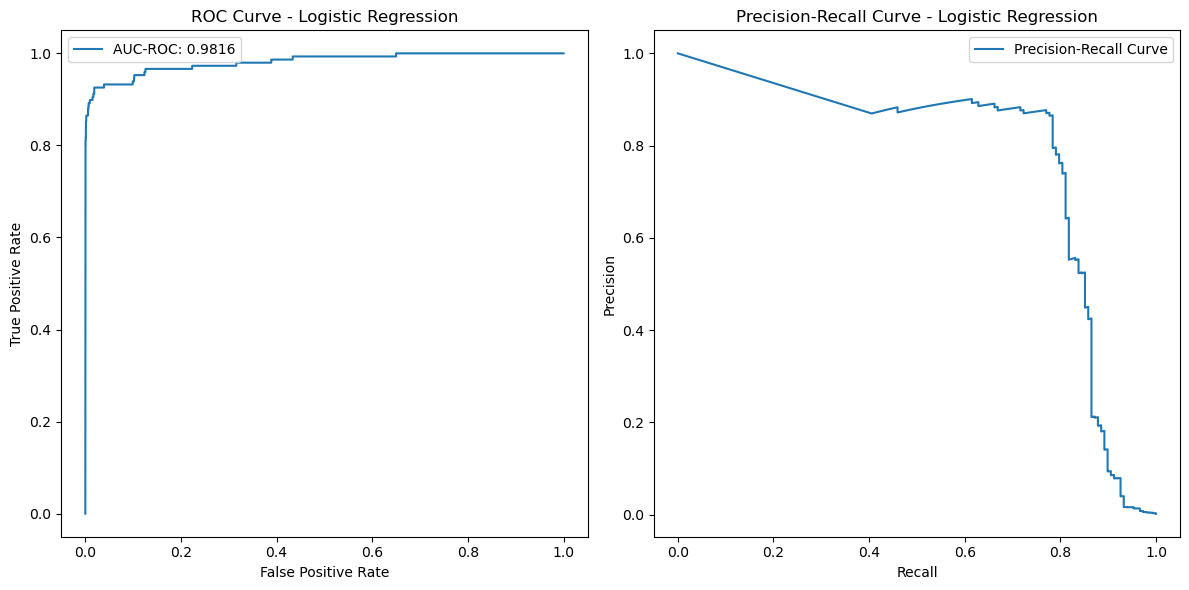

--- Random Forest ---


KeyboardInterrupt: 

In [ ]:
run_pipeline('over_sampling', X_train, y_train, X_test, y_test, {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier()
})

#### 2. Isolation Forest VS Local Outlier Factor

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    0.2s remaining:    1.2s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished


Isolation Forest:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     85295
           1       0.04      0.82      0.07       148

    accuracy                           0.96     85443
   macro avg       0.52      0.89      0.52     85443
weighted avg       1.00      0.96      0.98     85443



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


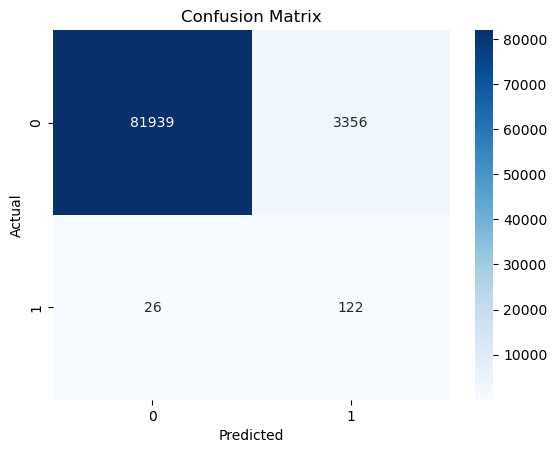

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


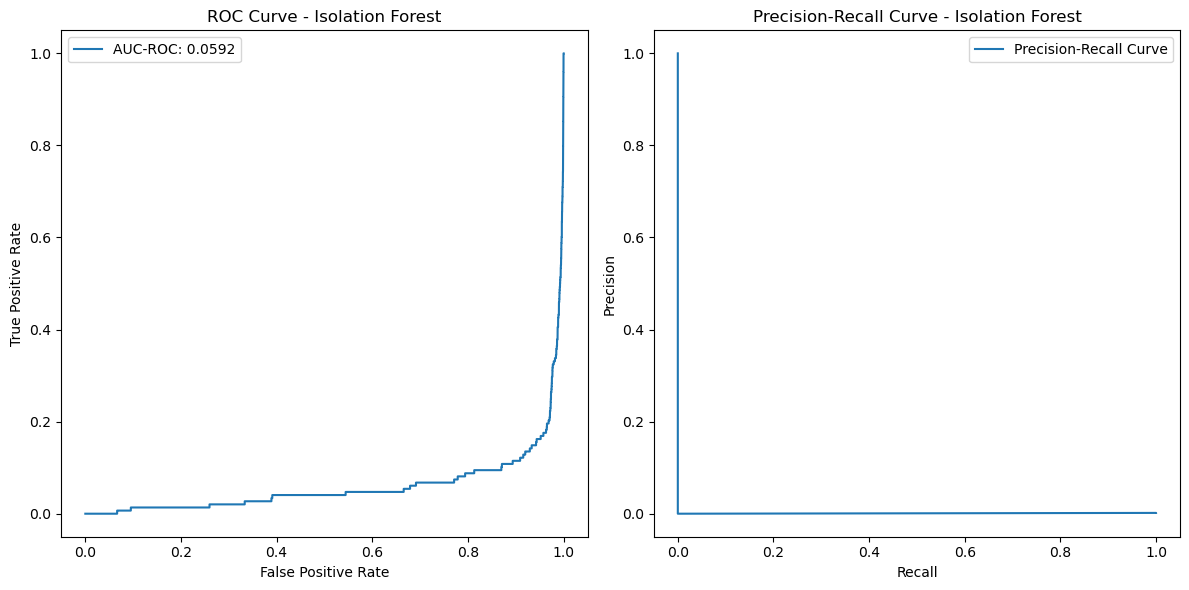

In [ ]:
# Create an Isolation Forest model
iso_forest = IsolationForest(
    n_estimators=100, 
    max_samples='auto', 
    contamination='auto', 
    max_features=1.0, 
    bootstrap=False, 
    n_jobs=-1, 
    random_state=42, 
    verbose=1, 
    warm_start=False
)

# Fit the model to the data
iso_forest.fit(X_train)

# Predict anomalies
y_pred_iso_forest = iso_forest.predict(X_test)  # -1 for outliers, 1 for normal points

# Convert predictions to binary (0 for inliers, 1 for outliers)
y_pred_iso_forest = np.where(y_pred_iso_forest == -1, 1, 0)

# Evaluate the performance
print("Isolation Forest:")
print(classification_report(y_test, y_pred_iso_forest))

# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred_iso_forest)

# Calculate the decision function scores
scores_iso_forest = iso_forest.decision_function(X_test)

# Plot ROC and Precision-Recall curves
plot_curves(y_test, scores_iso_forest, "Isolation Forest")

Local Outlier Factor:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    199020
           1       0.00      0.13      0.01       344

    accuracy                           0.94    199364
   macro avg       0.50      0.53      0.49    199364
weighted avg       1.00      0.94      0.97    199364



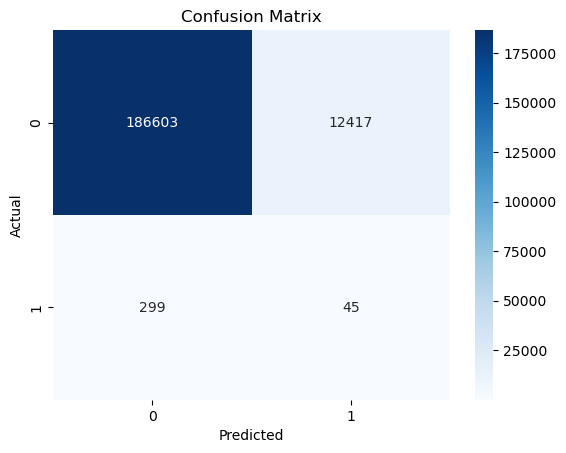

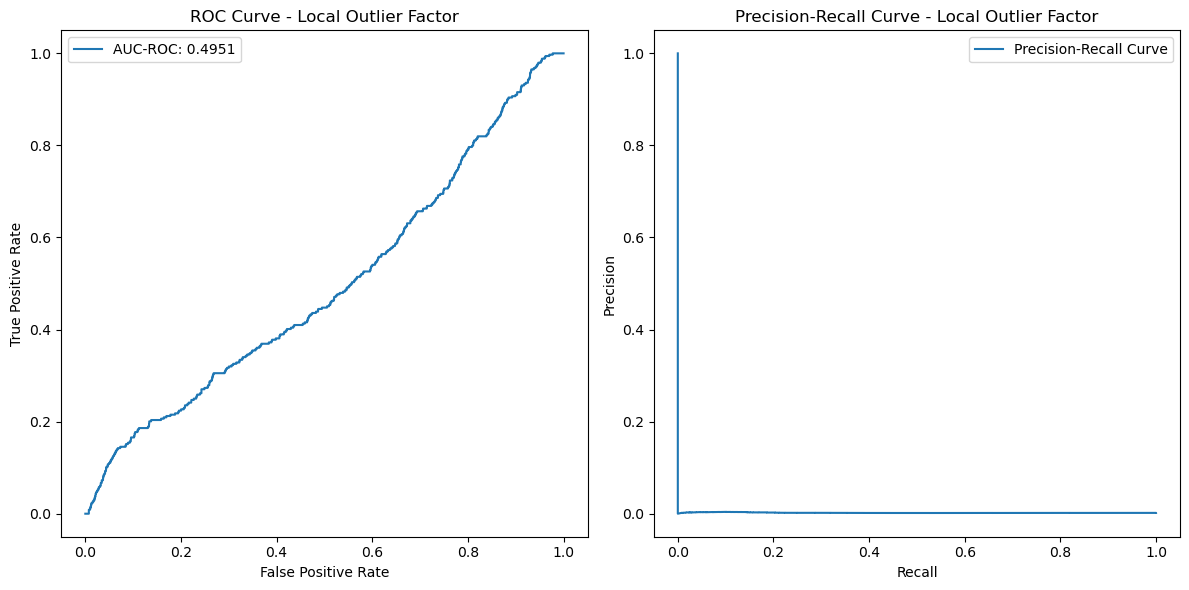

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

# Créer un modèle LOF
lof_model = LocalOutlierFactor(
    n_neighbors=20,
    algorithm='auto', 
    leaf_size=30, 
    metric='minkowski', 
    p=2, 
    metric_params=None, 
    contamination='auto', 
    novelty=False, 
    n_jobs=None
)

# Ajuster le modèle aux données
y_pred_lof = lof_model.fit_predict(X_train)

# Les scores négatifs des outliers
lof_scores = lof_model.negative_outlier_factor_

# Convertir les prédictions en binaire (0 pour inliers, 1 pour outliers)
y_pred_lof = np.where(y_pred_lof == -1, 1, 0)

# Évaluer les performances
print("Local Outlier Factor:")
print(classification_report(y_train, y_pred_lof))

# Afficher la matrice de confusion
plot_confusion_matrix(y_train, y_pred_lof)

# Afficher les courbes ROC et Precision-Recall
plot_curves(y_train, -lof_scores, "Local Outlier Factor")

Old kddcuf99 analysis

### A. Pré-processing

#### 1. Chargements des données

In [ ]:
kffcup_data = pd.read_csv('KFFCup99.zip', header=0)
kffcup_data.head()

duration protocol_type service flag  src_bytes  dst_bytes  land  \
0         0           tcp    http   SF        181       5450     0   
1         0           tcp    http   SF        239        486     0   
2         0           tcp    http   SF        235       1337     0   
3         0           tcp    http   SF        219       1337     0   
4         0           tcp    http   SF        217       2032     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                   9   
1               0       0    0  ...                  19   
2               0       0    0  ...                  29   
3               0       0    0  ...                  39   
4               0       0    0  ...                  49   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                     1.0                     0.0   
1                     1.0                     0.0   
2                     1.0                     0.0   
3                     1.0                     0.0   
4                     1.0                     0.0   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.11                          0.0   
1                         0.05                          0.0   
2                         0.03                          0.0   
3                         0.03                          0.0   
4                         0.02                          0.0   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                   0.0                       0.0                   0.0   
1                   0.0                       0.0                   0.0   
2                   0.0                       0.0                   0.0   
3                   0.0                       0.0                   0.0   
4                   0.0                       0.0                   0.0   

   dst_host_srv_rerror_rate   label  
0                       0.0  normal  
1                       0.0  normal  
2                       0.0  normal  
3                       0.0  normal  
4                       0.0  normal  

[5 rows x 42 columns]

#### 2. Description rapide des données

In [ ]:
df = kffcup_data.copy()
df.describe()

duration     src_bytes     dst_bytes           land  \
count  494020.000000  4.940200e+05  4.940200e+05  494020.000000   
mean       47.979400  3.025616e+03  8.685308e+02       0.000045   
std       707.747185  9.882191e+05  3.304003e+04       0.006673   
min         0.000000  0.000000e+00  0.000000e+00       0.000000   
25%         0.000000  4.500000e+01  0.000000e+00       0.000000   
50%         0.000000  5.200000e+02  0.000000e+00       0.000000   
75%         0.000000  1.032000e+03  0.000000e+00       0.000000   
max     58329.000000  6.933756e+08  5.155468e+06       1.000000   

       wrong_fragment         urgent            hot  num_failed_logins  \
count   494020.000000  494020.000000  494020.000000      494020.000000   
mean         0.006433       0.000014       0.034519           0.000152   
std          0.134805       0.005510       0.782103           0.015520   
min          0.000000       0.000000       0.000000           0.000000   
25%          0.000000       0.000000       0.000000           0.000000   
50%          0.000000       0.000000       0.000000           0.000000   
75%          0.000000       0.000000       0.000000           0.000000   
max          3.000000       3.000000      30.000000           5.000000   

           logged_in  lnum_compromised  ...  dst_host_count  \
count  494020.000000     494020.000000  ...   494020.000000   
mean        0.148245          0.010212  ...      232.471248   
std         0.355343          1.798328  ...       64.744601   
min         0.000000          0.000000  ...        0.000000   
25%         0.000000          0.000000  ...      255.000000   
50%         0.000000          0.000000  ...      255.000000   
75%         0.000000          0.000000  ...      255.000000   
max         1.000000        884.000000  ...      255.000000   

       dst_host_srv_count  dst_host_same_srv_rate  dst_host_diff_srv_rate  \
count       494020.000000           494020.000000           494020.000000   
mean           188.666052                0.753781                0.030906   
std            106.040205                0.410780                0.109259   
min              0.000000                0.000000                0.000000   
25%             46.000000                0.410000                0.000000   
50%            255.000000                1.000000                0.000000   
75%            255.000000                1.000000                0.040000   
max            255.000000                1.000000                1.000000   

       dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
count                494020.000000                494020.000000   
mean                      0.601936                     0.006684   
std                       0.481309                     0.042133   
min                       0.000000                     0.000000   
25%                       0.000000                     0.000000   
50%                       1.000000                     0.000000   
75%                       1.000000                     0.000000   
max                       1.000000                     1.000000   

       dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
count         494020.000000             494020.000000         494020.000000   
mean               0.176754                  0.176443              0.058118   
std                0.380593                  0.380920              0.230590   
min                0.000000                  0.000000              0.000000   
25%                0.000000                  0.000000              0.000000   
50%                0.000000                  0.000000              0.000000   
75%                0.000000                  0.000000              0.000000   
max                1.000000                  1.000000              1.000000   

       dst_host_srv_rerror_rate  
count             494020.000000  
mean                   0.057412  
std                    0.230141  
min                    0.00

#### 3. Définition des features et labels des données

In [ ]:
X = kffcup_data.drop('label', axis=1)
y = kffcup_data['label']

##### a. Réencodage des labels

In [ ]:
# Voir les valeures uniques de la colonne 'label'
y.value_counts()

label
smurf              280790
neptune            107201
normal              97277
back                 2203
satan                1589
ipsweep              1247
portsweep            1040
warezclient          1020
teardrop              979
pod                   264
nmap                  231
guess_passwd           53
buffer_overflow        30
land                   21
warezmaster            20
imap                   12
rootkit                10
loadmodule              9
ftp_write               8
multihop                7
phf                     4
perl                    3
spy                     2
Name: count, dtype: int64

Nous avons plusieurs classes différentes pour les labels ==> Problème multi classe ==> Pre-processing spécifique

In [ ]:
le = LabelEncoder()
y_multi_class = le.fit_transform(kffcup_data['label'])

##### b. Réencodage et normalisation des features

In [ ]:
# Identification des colonnes catégorielles et numériques
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['number']).columns

print(f"--- Variables catégorielles --- \n\n {categorical_cols} \n")
print(f"--- Variables numériques --- \n\n {numerical_cols} \n")

print(kffcup_data)


--- Variables catégorielles --- 

 Index(['protocol_type', 'service', 'flag'], dtype='object') 

--- Variables numériques --- 

 Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'lnum_compromised',
       'lroot_shell', 'lsu_attempted', 'lnum_root', 'lnum_file_creations',
       'lnum_shells', 'lnum_access_files', 'lnum_outbound_cmds',
       'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate'],
      dtype='object') 

        duration protocol_type service flag  src_bytes  dst_by

On voit qu'il y a des variables catégorielles à réencoder et des variables non normalisées ==> On va faire du One Hot Encoding et du RobustScaler (moins sensibles aux outliers)

In [ ]:
def preprocess_data(X, scaler=RobustScaler(), encoder=OneHotEncoder(sparse_output=False)):
    """
    Prétraite un DataFrame en appliquant un scaler aux colonnes numériques 
    et un one-hot encoder aux colonnes catégorielles.
    
    Parameters:
    - X : pd.DataFrame
        Le DataFrame d'entrée à transformer.
    - scaler : transformer, optional
        Le scaler à utiliser pour les colonnes numériques (par défaut RobustScaler).
    - encoder : transformer, optional
        L'encodeur à utiliser pour les colonnes catégorielles (par défaut OneHotEncoder).
    
    Returns:
    - pd.DataFrame
        Le DataFrame transformé avec les colonnes mises à jour.
    """
    # Identification des colonnes catégorielles et numériques
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    numerical_cols = X.select_dtypes(include=['number']).columns

    print(f"--- Variables catégorielles --- \n\n {categorical_cols} \n")
    print(f"--- Variables numériques --- \n\n {numerical_cols} \n")

    # Préparation du transformateur de colonnes
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', scaler, numerical_cols),
            ('cat', encoder, categorical_cols)
        ]
    )

    # Application des transformations
    X_processed = preprocessor.fit_transform(X)

    # Récupération des noms des colonnes transformées
    numerical_cols_transformed = numerical_cols
    categorical_cols_transformed = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)

    all_columns = list(numerical_cols_transformed) + list(categorical_cols_transformed)

    # Conversion en DataFrame avec les noms des colonnes
    X_transformed_df = pd.DataFrame(X_processed, columns=all_columns)

    return X_transformed_df

In [ ]:
X_transformed = preprocess_data(X)

--- Variables catégorielles --- 

 Index(['protocol_type', 'service', 'flag'], dtype='object') 

--- Variables numériques --- 

 Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'lnum_compromised',
       'lroot_shell', 'lsu_attempted', 'lnum_root', 'lnum_file_creations',
       'lnum_shells', 'lnum_access_files', 'lnum_outbound_cmds',
       'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate'],
      dtype='object') 



#### 4. Déséquilibre des classes ? 

Pourcentage de smurf: 56.84%
Pourcentage de neptune: 21.70%
Pourcentage de normal: 19.69%
Pourcentage de back: 0.45%
Pourcentage de satan: 0.32%
Pourcentage de ipsweep: 0.25%
Pourcentage de portsweep: 0.21%
Pourcentage de warezclient: 0.21%
Pourcentage de teardrop: 0.20%
Pourcentage de pod: 0.05%
Pourcentage de nmap: 0.05%
Pourcentage de guess_passwd: 0.01%
Pourcentage de buffer_overflow: 0.01%
Pourcentage de land: 0.00%
Pourcentage de warezmaster: 0.00%
Pourcentage de imap: 0.00%
Pourcentage de rootkit: 0.00%
Pourcentage de loadmodule: 0.00%
Pourcentage de ftp_write: 0.00%
Pourcentage de multihop: 0.00%
Pourcentage de phf: 0.00%
Pourcentage de perl: 0.00%
Pourcentage de spy: 0.00%


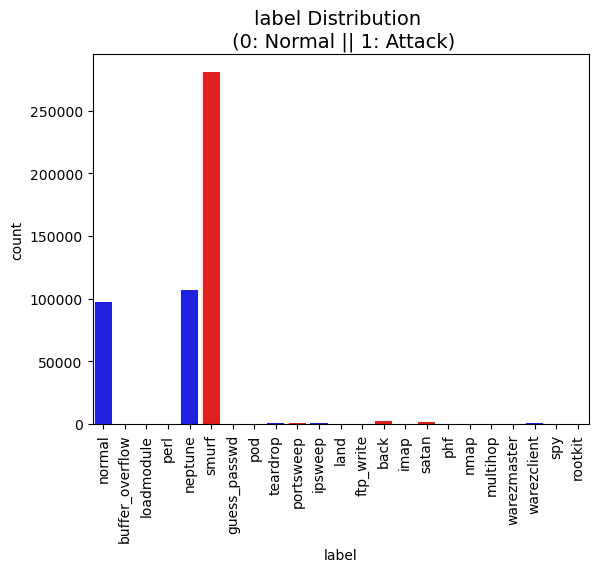

In [ ]:
plot_class_distribution(kffcup_data, 'label', class_labels={0: "Normal", 1: "Attack"})

#### 5. Split dataset

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

# Define the features (X) and the target (y)
X = X_transformed
y = y_multi_class

# Initialize StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=4, test_size=0.3, random_state=42)

# Perform the split
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Verify the distribution in the splits
print("Distribution in the original dataset:")
print(pd.Series(y).value_counts(normalize=True))
print("\nDistribution in the training set:")
print(pd.Series(y_train).value_counts(normalize=True))
print("\nDistribution in the test set:")
print(pd.Series(y_test).value_counts(normalize=True))

Distribution in the original dataset:
18    0.568378
9     0.216997
11    0.196909
0     0.004459
17    0.003216
5     0.002524
15    0.002105
21    0.002065
20    0.001982
14    0.000534
10    0.000468
3     0.000107
1     0.000061
6     0.000043
22    0.000040
4     0.000024
16    0.000020
7     0.000018
2     0.000016
8     0.000014
13    0.000008
12    0.000006
19    0.000004
Name: proportion, dtype: float64

Distribution in the training set:
18    0.568378
9     0.216998
11    0.196909
0     0.004459
17    0.003216
5     0.002524
15    0.002105
21    0.002065
20    0.001981
14    0.000535
10    0.000468
3     0.000107
1     0.000061
6     0.000043
22    0.000040
4     0.000023
16    0.000020
2     0.000017
7     0.000017
8     0.000014
13    0.000009
12    0.000006
19    0.000003
Name: proportion, dtype: float64

Distribution in the test set:
18    0.568378
9     0.216995
11    0.196908
0     0.004460
17    0.003218
5     0.002524
15    0.002105
21    0.002065
20    0.001984
14   

### B. Processing des données

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Modèle avec stratégie multinomial (Softmax)
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

# Entraînement
log_reg.fit(X_train, y_train)

# Prédictions
y_pred = log_reg.predict(X_test)

# Rapport de classification
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.69      0.99      0.81       661
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00       374
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         2
           9       0.96      1.00      0.98     32160
          10       0.00      0.00      0.00        69
          11       0.97      0.95      0.96     29183
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00        79
          15       0.38      0.08      0.13       312
          16       0.00      0.00      0.00         3
          17       0.00    

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Modèle de Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraînement
rf_clf.fit(X_train, y_train)

# Prédictions
y_pred = rf_clf.predict(X_test)

# Rapport de classification
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       661
           1       0.78      0.78      0.78         9
           2       0.00      0.00      0.00         2
           3       1.00      0.94      0.97        16
           4       1.00      0.50      0.67         4
           5       1.00      1.00      1.00       374
           6       0.86      1.00      0.92         6
           7       0.50      0.33      0.40         3
           8       1.00      0.50      0.67         2
           9       1.00      1.00      1.00     32160
          10       1.00      0.99      0.99        69
          11       1.00      1.00      1.00     29183
          12       0.00      0.00      0.00         1
          13       1.00      1.00      1.00         1
          14       0.98      1.00      0.99        79
          15       1.00      1.00      1.00       312
          16       0.00      0.00      0.00         3
          17       1.00    